# Clustering Questions and Answers from StackExchange sites.

We use tha data available from StackExchange to analyze the behavior of Questions and Answers by applying different clustering algorithms. The main goal is to obtain information about users behavior and how we can use it to create an efficient algorithm for question routing. The basic workflow of the initial exploration is based in a document clustering work by [@brandonmrose](http://brandonrose.org/clustering).

## The data

We start exploring data from the site [travel.stackexchange.com](http://travel.stackexchange.com). First we import neccessary libraries and then we store the data from the SQL database in lists. Some parsing of the text is performed in order to eliminate unwanted text (numbers, punctuation,...).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
import csv
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from string import ascii_lowercase
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import sqlite3
from nltk.stem.snowball import SnowballStemmer

import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import random as rd
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity

import itertools



In [8]:
conn=sqlite3.connect('/Users/cepardot/GoogleDrive/EP/Stage/stackoverflowanalysis-188/db/travel.db')
#conn=sqlite3.connect('/Volumes/DavidPardo/Stage/math.db')

c=conn.cursor()
def runquery(c,query):
  c.execute(query)
  return c.fetchall()
result=runquery(c,'''SELECT ParentId, Id, PostTypeId, Body, OwnerUserId, AnswerCount, AcceptedAnswerId, Score, Title FROM posts WHERE Id<10000;''') #ParentId<10000 OR Id<10000;''')
result2=runquery(c,'''SELECT PostId, Id, UserId FROM comments WHERE PostId<10000;''')
result3=runquery(c,'''SELECT PostId, Id, UserId, CreationDate FROM votes WHERE PostId<10000;''')
ParentId=[]
Id=[]
TypeId=[]
Text=[]
UserId=[]
AnswerCount=[]
AcceptedAnswer=[]
Score=[]
Title=[]
for row in result:
    ParentId.append(row[0])
    Id.append(row[1])
    TypeId.append(row[2])
    UserId.append(row[4])
    AnswerCount.append(row[5])
    AcceptedAnswer.append(row[6])
    Score.append(row[7])
    Title.append(row[8])
    
    
    
    
    #To eliminate code (latex)
    sample=re.sub(r'<pre>(.|\n)*?<\/pre>',r' ',row[3])
    sample=re.sub('((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', ' ', sample)
    
    
    
    #To eliminate URL's
    
    #sample=re.sub('<a href="?\'?([^"\'>]*)', ' ', sample)
    sample=re.sub('<[^<]+?>', ' ', sample)
    
    
    sample=re.sub(r'$(.*?)$',r' ',sample)
    sample=re.sub(r'[^a-zA-Z ]', ' ', sample)
    # sample=re.sub(r'[?|$|.|!|{|}|\^|/]',r'',sample)
    # sample=re.sub(r"['|\\]",r' ',sample)
    # sample=re.sub(r'\w*\d\w*', r' ', sample)
    sample=re.sub(r" [a-zA-Z] ",r' ',sample)
    sample.encode('utf-8').strip()
    Text.append(sample)
    
CParentId=[]
CId=[]
CUserId=[]
for row in result2:
    CParentId.append(row[0])
    CId.append(row[1])
    CUserId.append(row[2])
    
VParentId=[]
VId=[]
VUserId=[]
VCreationDate=[]
for row in result3:
    VParentId.append(row[0])
    VId.append(row[1])
    VUserId.append(row[2])
    VCreationDate.append(row[3])

We store all the data in a Pandas dataframe. Id's are read as floats, but we reconvert them into integers so as to facilitate comparisons in forthcoming steps

In [9]:
df = pd.DataFrame({'Id':Id,'ParentId':ParentId,'TypeId':TypeId,'Text':Text, 'UserId':UserId,'AnswerCount':AnswerCount,
                   'AcceptedAnswer':AcceptedAnswer,'Score':Score,'Title':Title})

#df.set_value(df.loc[np.isnan(df.UserId)],UserId)=-2
df.UserId.loc[np.isnan(df.UserId)]=-2
df.UserId=df.UserId.astype(int)

dfC = pd.DataFrame({'Id':CId,'ParentId':CParentId, 'UserId':CUserId})

dfC.UserId.loc[np.isnan(dfC.UserId)]=-2
dfC.UserId=dfC.UserId.astype(int)

dfV = pd.DataFrame({'Id':VId,'ParentId':VParentId, 'UserId':VUserId, 'CreationDate':VCreationDate})

dfV.UserId.loc[np.isnan(dfV.UserId)]=-2
dfV.UserId=dfV.UserId.astype(int)

In [10]:
#####Text preprocessing
stemmer = SnowballStemmer("english")
stop = stopwords.words('english')
stoplist = [stemmer.stem(t) for t in stop]
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist))) 

# remove characters and stoplist words, then generate dictionary of unique words
df.Title.loc[df.TypeId==1].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*df.loc[df.TypeId==1].Title.str.split(' ')))))).split(" "))
df.Title.loc[df.TypeId==1] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in df.loc[df.TypeId==1].Title.str.lower().str.split(' ')]

# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 2
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*df.loc[df.TypeId==1].Title.str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
df.Title.loc[df.TypeId==1] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in df.loc[df.TypeId==1].Title.str.split(' ')]
df.Title.loc[df.TypeId==1] = [["".join(stemmer.stem(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]','', word)) for word in next_text)] for next_text in df.loc[df.TypeId==1].Title  ]

# run word2vec model and then save it
texts_stemmed = filter(None, [next_text[0].strip(' ').split(' ') for next_text in df.loc[df.TypeId==1].Title])

w2vmodel_stemmed = gensim.models.Word2Vec(texts_stemmed, size=100, window=5, min_count=5, workers=4)
w2vmodel_stemmed.save('w2v_stemmed_model')


In [11]:
def avg_feature_vector(sentence, model, num_features):
        words=sentence[0].split()
        #function to average all words vectors in a given paragraph
        featureVec = np.zeros((num_features,), dtype="float32")
        nwords = 0

        #list containing names of words in the vocabulary
        index2word_set = set(model.index2word) 
        #this is moved as input param for performance reasons
        for word in words:
            if word in index2word_set:
                nwords = nwords+1
                featureVec = np.add(featureVec, model[word])

        if(nwords>0):
            featureVec = np.divide(featureVec, nwords)
        return featureVec

In [ ]:
model = gensim.models.Word2Vec.load('w2v_stemmed_model')
model['computer']
sentence_1 = df.Title[0]
sentence_1_avg_vector = avg_feature_vector(sentence_1, model=model, num_features=100)

#get average vector for sentence 2
sentence_2 = df.Title[1]
sentence_2_avg_vector = avg_feature_vector(sentence_2, model=model, num_features=100)


sen1_sen2_similarity =  cosine_similarity(sentence_1_avg_vector,sentence_2_avg_vector)
print(sen1_sen2_similarity)

In [12]:
model = gensim.models.Word2Vec.load('w2v_stemmed_model')
df.Title.loc[df.TypeId==1]=df.loc[df.TypeId==1].Title.apply(avg_feature_vector, model=model, num_features=100)

In [ ]:
print(len(df[df.TypeId==1]))
print(len(df[df.TypeId==2]))
print(len(dfC[dfC.UserId!=-2]))
print(len(dfV[dfV.UserId!=-2]))
print(len(dfC))
print(len(dfV))

In [ ]:
from __future__ import print_function
b=1
f = open('workfile', 'w')
print(repr(b)+"a",file=f)

In [ ]:
dfVmod=dfV[dfV.UserId!=-2]
dfVmod2=dfV[dfV.UserId==-2]
print(dfVmod2.CreationDate)

## Creating a feature space: Tf-idf matrix

In order to apply clustering algorithms we have two options: 

1. Embed the texts as points in an abstract highdimensional space.
2. Define a similarity measure among texts.

We first explore the former option. By creating a Tf-idf matrix we express each text as a vector where each component represents a word and its relative importance within it relative to its relevance among all the corpus. While creating the matrix we eliminate the most common english words (stopwords) and we stem the vocabulary in order to avoid multiple instances of the same root. 

In [ ]:
###English stopwords and a stemming engine are imported

stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

###############################################
###Functions for tokenize and stem the posts###
###############################################

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

###Questions and Answers are selected

Texts=df.Text
Questions=df.Text[df.TypeId==1]
Answers=df.Text[df.TypeId==2]

###Function for creating the tf-idf matrix
from sklearn.feature_extraction.text import CountVectorizer
def create_tfidf(texts):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(Texts)
    X_train_counts.shape
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    ###Creates a list of tokens and a list of stems.###
    for i in texts:
        allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

    tfidf_vectorizer = TfidfVectorizer(max_df=0.1, max_features=50000,
                                 min_df=0.01, stop_words='english',
            use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

    tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

    terms = tfidf_vectorizer.get_feature_names()
    similarity=cosine_similarity(tfidf_matrix)
    dist = 1 - similarity
    return tfidf_matrix,similarity,dist,vocab_frame,terms

###tf-idf's for questions and answers are calculated separately.

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

tfidf_matrixQComplete, similarityQ, distQ, vocab_frameQ, termsQ=create_tfidf(Questions)
tfidf_matrixAComplete, similarityA, distA, vocab_frameA, termsA=create_tfidf(Answers)


In [ ]:
nltk.download()

## Dimensionality reduction: SVD

We use Singular Value Decomposition to reduce the dimensionality of our space from around 1000 dimensions to the 5 that are more important according to the method.

In [ ]:
def svd(tfidf_matrix):
    svd = TruncatedSVD(n_components=100)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    tfidf_matrix= svd.fit_transform(tfidf_matrix)
    return svd, tfidf_matrix
svdQ, tfidf_matrixQ=svd(tfidf_matrixQComplete)
svdA, tfidf_matrixA=svd(tfidf_matrixAComplete)

## Number of clusters

Several clustering algorithms require as input the number of clusters, however in this kind of exploratory work we don't have a good idea about what it could be. Different techniques exist to estimate this number based on the data, we use Sillouhette Analysis to get a first idea.

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
X=tfidf_matrixAComplete
range_n_clusters = [8]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.2])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.get_shape()[0] + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values",fontsize=16)
    ax1.set_ylabel("Cluster label",fontsize=16)

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.1,0.2])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().xaxis.set_ticks_position('bottom')
    

   
    #plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  #"with n_clusters = %d" % n_clusters),
                 #fontsize=14, fontweight='bold')
    plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/silhouette.eps', bbox_inches='tight')
    plt.show()


In [ ]:
X.get_shape()[1]


We observe a significant reduction in the sillouhette score when going from 5 to 6 clusters. Another perceptible decrease is observed when going from 9 to 10, thus we explore k=5 and k=9. What we observe is a redundancy of topics when k=9 and 4 well defined topics when k=4. However the biggest cluster seems to be an eclectic mixture of texts with no distinguishable topic in common. A possible approach is to perform yet another clustering over this big group. 

## K-means

As a first clustering algorithm we try one of the oldest and yet the most used one still, k-means. Different random initializations are performed in order to obtain a better and more stable clustering.

In [ ]:
num_clustersQ = 20
num_clustersA = 20
kmQ = KMeans(n_clusters=num_clustersQ)
kmA = KMeans(n_clusters=num_clustersA)
kmQ.fit(tfidf_matrixQComplete)
kmA.fit(tfidf_matrixAComplete)
clustersQ = kmQ.labels_.tolist()
clustersA = kmA.labels_.tolist()
centersQ=kmQ.cluster_centers_#svdQ.inverse_transform(kmQ.cluster_centers_)
centersA=kmA.cluster_centers_#svdA.inverse_transform(kmA.cluster_centers_)
df['clustersKmeans']=np.empty(len(df.Text)).fill(np.nan)
df.loc[df.TypeId==1,'clustersKmeans']=clustersQ
df.loc[df.TypeId==2,'clustersKmeans']=clustersA

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroidsQ = centersQ.argsort()[:, ::-1]
order_centroidsA = centersA.argsort()[:, ::-1]
#order_centroids = af.cluster_centers_.argsort()[:, ::-1]
#Dictionary that will be used for plotting
def keywords(num_clusters,order_centroids,terms,typeId,vocab_frame):
    cluster_names={}
    cluster_colors={}
    total_list=[]
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        alist=[]
        for ind in order_centroids[i, :5]: #replace 6 with n words per cluster
            alist.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        cluster_names[i]=alist
        total_list.append(alist)
        cluster_colors[i]="#%06x" % rm.randint(0, 0xFFFFFF)
        print() #add whitespace
        print() #add whitespace
        grouping=df[np.logical_and(df.clustersKmeans==i, df.TypeId==typeId)][['Id','ParentId']]
        print("Cluster %d (Id, parent's Id):" % i, end='')
    
        for title in grouping.iterrows():
            #print(title[0] + ', ')
            #if title[1]=='nan':
            #    title=str(title[0])
            #else
            #    title=str(title[1])
            print(' (%s,' % str(title[1].ParentId) + '%s), ' % str(title[1].Id), end='')
        print() #add whitespace
        print() #add whitespace
    
    print()
    print()
    return total_list
clustersA_names=keywords(num_clustersA,order_centroidsA,termsA,1,vocab_frameA)

In [ ]:
#cluster_df = pd.DataFrame({'Id':Id,'ParentId':ParentId,'TypeId':TypeId,'Text':Text, 'UserId':UserId})
dictionary={}
for cluster in set(clustersQ):
    
    counts=[]
    questions=df[np.logical_and(df.clustersKmeans==cluster, df.TypeId==1)]
    answers=df[np.logical_and(df.ParentId.isin(np.array(questions.Id)), df.TypeId==2)]
    size=len(answers)
    for clusterA in set(answers.clustersKmeans):
        counts.append(float(len(answers[df.clustersKmeans==clusterA]))/size)
    dictionary["Cluster{0}".format(cluster)]=counts
    #dictionary[clustersQ_names[cluster]]=counts
            
    
    

In [ ]:
dictionary

In [ ]:
print(clustersQ_names)
print(clustersA_names)

In [ ]:
dictionaryUsers={}
for cluster in set(clustersQ):
    
    counts=[]
    questions=df[np.logical_and(df.clustersKmeans==cluster, df.TypeId==1)]
    answers=df[np.logical_and(df.ParentId.isin(np.array(questions.Id)), df.TypeId==2)]
    number_users=len(set(df[df.TypeId==2].Id))
    size=len(set(answers.Id))
    print(float(size)/number_users)
    for clusterA in set(answers.clustersKmeans):
        counts.append(float(len(set(answers[df.clustersKmeans==clusterA].Id)))/size)
    dictionaryUsers["Cluster{0}".format(cluster)]=counts
    #dictionary[clustersQ_names[cluster]]=counts

In [ ]:
dictionaryUsers

## Affinity Propagation

A clustering technique which does not require the input of a chosen number of clusters. However, for large dimensions it seems to yield too many small clusters. A lot of them seem to have well defined topics, although frequently redundant.

In [ ]:
num_clustersQS = 5
num_clustersAS = 5
kmQS = KMeans(n_clusters=num_clustersQ)
kmAS = KMeans(n_clusters=num_clustersA)
##It takes the submatrix corresponding to the texts clustered in the biggest component
#kmQS.fit(
#tfidf_matrixQComplete[df[np.logical_and(df.clustersKmeans==0, df.TypeId==1)].index.values,:]
#)

TextsS=df[df.clustersKmeans==0].Text
QuestionsS=TextsS[df.TypeId==1]
AnswersS=TextsS[df.TypeId==2]
tfidf_matrixQComplete, similarityQ, distQ, vocab_frameQ, termsQ=create_tfidf(QuestionsS)
tfidf_matrixAComplete, similarityA, distA, vocab_frameA, termsA=create_tfidf(AnswersS)
kmAS.fit(tfidf_matrixAComplete)#[df[np.logical_and(df.clustersKmeans==0, df.TypeId==2)].index.values,:])
#clustersQS = kmQS.labels_.tolist()
clustersAS = kmAS.labels_.tolist()
#centersQS=kmQ.cluster_centers_#svdQ.inverse_transform(kmQ.cluster_centers_)
centersAS=kmAS.cluster_centers_#svdA.inverse_transform(kmA.cluster_centers_)
df['clustersKmeansS']=np.empty(len(df.Text)).fill(np.nan)
#df.loc[np.logical_and(df.clustersKmeans==0, df.TypeId==1),'clustersKmeansS']=clustersQS
df.loc[np.logical_and(df.clustersKmeans==0, df.TypeId==2),'clustersKmeansS']=clustersAS

from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
#order_centroidsQS = centersQS.argsort()[:, ::-1]
order_centroidsAS = centersAS.argsort()[:, ::-1]
#order_centroids = af.cluster_centers_.argsort()[:, ::-1]
#Dictionary that will be used for plotting
def keywords(num_clusters,order_centroids,terms,typeId,vocab_frame):
    cluster_names={}
    cluster_colors={}
    
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        alist=[]
        for ind in order_centroids[i, :5]: #replace 6 with n words per cluster
            alist.append(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        cluster_names[i]=alist
        cluster_colors[i]="#%06x" % rd.randint(0, 0xFFFFFF)
        print() #add whitespace
        print() #add whitespace
        grouping=df[np.logical_and(df.clustersKmeans==i, df.TypeId==typeId)][['Id','ParentId']]
        print("Cluster %d (Id, parent's Id):" % i, end='')
    
        for title in grouping.iterrows():
            #print(title[0] + ', ')
            #if title[1]=='nan':
            #    title=str(title[0])
            #else
            #    title=str(title[1])
            print(' (%s,' % str(title[1].ParentId) + '%s), ' % str(title[1].Id), end='')
        print() #add whitespace
        print() #add whitespace
    
    print()
    print()
keywords(num_clustersAS,order_centroidsAS,termsA,2,vocab_frameA)

In [ ]:
df[np.logical_and(df.clustersKmeans==0, df.TypeId==2)].index.values

## Spectral Clustering

This technique provides the most promising results so far, with good speed and well defined topics (except for the biggest one). Besides it can be used with both the Tf-idf and Joint Complexity methods. The selection of the number of clusters keeps being the most important problem.

In [ ]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(affinity='precomputed').fit(similarityA)
clustersS = sc.labels_.tolist()
df['clustersSpectral']=np.empty(len(df.Text)).fill(np.nan)
df.loc[df.TypeId==1,'clustersSpectral']=-1
df.loc[df.TypeId==2,'clustersSpectral']=clustersS
difClusters=set(clustersS)
num_words=tfidf_matrixAComplete.get_shape()[1]
cluster_namesS={}
cluster_colorsS={}
for cluster in difClusters:
    indices=np.where(df.clustersSpectral[df.TypeId==2]==cluster)[0]
    sum_vectors=np.zeros(num_words)
    for i in indices:
        sum_vectors=sum_vectors+tfidf_matrixAComplete[i,:]
    order_centroidsS=np.array(sum_vectors.argsort()[:, ::-1])[0]
    print("Cluster %d words:" % cluster, end='')
    alist=[]
    for ind in order_centroidsS[:5]: #replace 6 with n words per cluster
    #for ind in np.squeeze(np.asarray(order_centroidsA[i,:5])): #replace 6 with n words per cluster
        alist.append(vocab_frameA.ix[termsA[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
        print(' %s' % vocab_frameA.ix[termsA[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    cluster_namesS[cluster]=alist
    cluster_colorsS[cluster]="#%06x" % rd.randint(0, 0xFFFFFF)
    print() #add whitespace
    print() #add whitespace
    grouping=df[np.logical_and(df.clustersSpectral==cluster, df.TypeId==2)][['Id','ParentId','UserId']]
    print("Cluster %d parent's Id:" % i, end='')
    
    for title in grouping.iterrows():
        #print(title[0] + ', ')
        #if title[1]=='nan':
        #    title=str(title[0])
        #else
        #    title=str(title[1])
        print(' (Parent Id: %s, ' % str(title[1].ParentId) + 'Id: %s, ' % str(title[1].Id) + 'UserId: %s), ' % str(title[1].UserId), end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

## Agglomerative Hierarchical clustering

A hierarchical clustering can give us an idea of how separated and well defined the different topics are. We observe a huge cluster of similar (probably poorly defined) topics and only two small independent clusters. The latter are likely to be specific topics with its own vocabulary.

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(distA) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=df.ParentId[df.TypeId==2].tolist());

plt.tick_params(
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout


## Topic Identification: LDA

A probabilistic graphical model can be used to identify topics in a corpus. Through Latent Dirichlet Analysis we obtain a list of topics represented by the words with the highest probability of being used within them. The topics seem to coincide with the ones obtained through Kmeans, i.e. one ill-defined one and four very specifics ones.

In [ ]:
#########
###LDA###
#########

#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in df.Text[df.TypeId==2]]

#tokenize
tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, num_topics=20, id2word=dictionary, update_every=5, chunksize=10000, passes=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = [[a[0] for a in topics_matrix[i][1]] for i in range(10)]
topics_matrix = np.array(topics_matrix)


for i in topics_matrix:
    print([str(word) for word in i])
    print()

## Clustering Ensembles: Evidence accumulation

This is an idea that might proof useful for both finding the ideal number of clusters and getting a better clustering than with more traditional methods. It basically consists on performing n different clusterings (K-means for example) and smartly averaging the results so that clusters are formed according to the frequency in which points were assigned to the same cluster in the individual runs. In progress.

In [ ]:
from scipy.sparse import csr_matrix
def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')

from scipy.sparse.csgraph import minimum_spanning_tree

from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse.csgraph import connected_components

from sklearn.base import BaseEstimator, ClusterMixin
class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
        
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X))
                 for i in range(self.n_clusterings)))/self.n_clusterings
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        self.n_components, self.labels_ = connected_components(mst)
        return self
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
clusterer=EAC(cut_threshold=0.5)
clusterer.fit(tfidf_matrixA)

print(clusterer.n_components)

# Joint Complexity

Another approach consists on creating a similarity measure between texts via Joint Complexity. In this case we wouldn't have the specific information of the points in a multidimensional space, thus we would need to use algorithms that detect clusters from a similarity matrix, such as Affinity propagation and Spectral Clustering. Affinity propagation yielded very similar results to those found when using the Tf-idf approach.

In [ ]:
import jpype
from jpype import *
 
#startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=/Users/cepardot/GoogleDrive/EP/Stage/stackoverflowanalysis-188/db/CoreJointComplexity/bin")
 
testPkg = JPackage('com').alblf.jc
Test = testPkg.SuffixTree
numText=len(df.Text[df.TypeId==2])-2

#def add_center(cluster_centers,clusters,ind, element):
#    cluster_centers.append(element)
#    clusters.append(ind)
#    ind+=1
    
def greedy(radius,texts):
    cluster_centers=[]
    clusters=[]
    ind=0
    for i in range(numText):
        #a=Test(df.Text[df.TypeId==2][i])
        a=Test(texts.iloc[i])
        if not cluster_centers:
            cluster_centers.append(i)
            clusters.append(ind)
            ind+=1
        else:
            dist=[]
            taken=False
            for j in range(len(cluster_centers)):
                #b=Test(df.Text[df.TypeId==2][center])
                b=Test(texts.iloc[j])
                #similarity=a.normalizedJC(b)
                similarity=a.countCommonFactors(b)
                similarity=(similarity/0.005 if similarity<0.005 else 1)
                if similarity<radius:
                    cluster=j
                    clusters.append(cluster)
                    taken=True
                    break
                #dist.append(similarity)
            #if np.min(dist)<radius:
            #    cluster=np.argmin(dist)
            #    clusters.append(cluster)
                
            if not taken:
                cluster_centers.append(i)
                clusters.append(ind)
                ind+=1
    return cluster_centers, clusters

#cluster_centers, clusters=greedy(1,df.Text[df.TypeId==2])

In [ ]:
#Not really a greedy algorithm, I'm not removing all possible points!!!!
def greedy(radius,points,df):
    #cluster_centers=[]
    cluster_center=points[0]
    data=points[1]
    clusters=[]
    new_cluster_centers=[]
    
    ind=0
    #for i in range(len(cluster_centers)):
    new_cluster_centers.append([cluster_center,[]])
    #print(new_cluster_centers)
    for i in data:
        if i!=cluster_center:
            #a=Test(df.Text[df.TypeId==2][i])
            a=Test(df.Text[df.TypeId==2].iloc[i])
            #if not cluster_centers:
            #    cluster_centers.append(i)
            #    clusters.append(ind)
            #    ind+=1
            #else:
            dist=[]
            taken=False
            for j in range(len(new_cluster_centers)):
                #b=Test(df.Text[df.TypeId==2][center])
                b=Test(df.Text[df.TypeId==2].iloc[new_cluster_centers[j][0]])
                similarity=a.normalizedJC(b)
                similarity=(similarity/0.005 if similarity<0.005 else 1)
                if similarity>radius:
                    cluster=new_cluster_centers[j][0]
                    clusters.append(cluster)
                    ###TODO###
                    new_cluster_centers[j][1].append(i)
                    taken=True
                    break
                    #dist.append(similarity)
                    #if np.min(dist)<radius:
                    #    cluster=np.argmin(dist)
                    #    clusters.append(cluster)
                
            if not taken:
                new_cluster_centers.append([i,[]])
                #print(new_cluster_centers)
                clusters.append(i)
                
    return new_cluster_centers, clusters

In [ ]:
a=Test("holhtrthg crthcey he cyh tyhcrtyh r uyjv  ijviu fh  gtrrtft gy  rhr y  uj u jhyt gtfr f  fttyh ")
print(a)
b=Test("f hjfn  df gd fg df g gf gfd gfd grfd  er rt g rg  gt t g rgt r tg er g rt e rt")
print(b)
c=a.normalizedJC(b)
print(c)
texts=df.Text[df.TypeId==2]
a1=Test(str(texts.iloc[0]))
print(a1)
b1=Test(str(texts.iloc[1]))
print(str(texts.iloc[0]))
print(str(texts.iloc[1]))
c1=a1.normalizedJC(b1)
print(texts.iloc[0])

In [ ]:
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

#text1 = 'This is a foo bar sentence .'
#text2 = 'This sentence is similar to a foo bar sentence .'

#vector1 = text_to_vector(text1)
#vector2 = text_to_vector(text2)

#cosine = get_cosine(vector1, vector2)

#print 'Cosine:', cosine


#Not really a greedy algorithm, I'm not removing all possible points!!!!
def greedy(radius,points,df):
    #cluster_centers=[]
    cluster_center=points[0]
    data=points[1]
    #data.remove(cluster_center)
    #clusters=[]
    new_cluster_centers=[]
    
    ind=0
    #for i in range(len(cluster_centers)):
    new_cluster_centers.append([cluster_center,[]])
    #print(new_cluster_centers)
    j=0
    while data:
        b=text_to_vector(df.Text[df.TypeId==2].iloc[cluster_center])#Test(df.Text[df.TypeId==2].iloc[cluster_center])
        for i in data:
            if i==cluster_center:
                data.remove(i)
                #a=Test(df.Text[df.TypeId==2][i])
            else:
                a=text_to_vector(df.Text[df.TypeId==2].iloc[i])#Test(df.Text[df.TypeId==2].iloc[i])
            #if not cluster_centers:
            #    cluster_centers.append(i)
            #    clusters.append(ind)
            #    ind+=1
            #else:
                dist=[]
                taken=False
                #for j in range(len(new_cluster_centers)):
                #b=Test(df.Text[df.TypeId==2][center])
                #b=Test(df.Text[df.TypeId==2].iloc[new_cluster_centers[j][0]])
                #similarity=a.normalizedJC(b)
                similarity=get_cosine(a, b)
                #similarity=(similarity/0.005 if similarity<0.005 else 1)
                #distance=1./similarity
                if similarity>radius:
                    cluster=new_cluster_centers[j][0]
                    #clusters.append(cluster)
                    ###TODO###
                    new_cluster_centers[j][1].append(i)
                    data.remove(i)
                    #taken=True
                    #break
                    #dist.append(similarity)
                    #if np.min(dist)<radius:
                    #    cluster=np.argmin(dist)
                    #    clusters.append(cluster)
                
        if data:
            new_cluster_centers.append([data[0],[]])
            
            cluster_center=data[0]
            data.remove(data[0])
                #print(new_cluster_centers)
                #clusters.append(i)
            j+=1
            print(j)
    print(' # ')            
    return new_cluster_centers

In [ ]:
from rd import randint
def build_tree(df,n):
    tree=[]
    radius=1.
    number_points=len(df.Text[df.TypeId==2])
    data=list(range(number_points))
    cluster_center=0#randint(0,number_points)
    points=[[cluster_center,data]]
    for i in range(n):
        new_points=[]
        for point in points:
            new_cluster_centers=greedy(radius,point,df)
            tree.append([point[0],[child[0] for child in new_cluster_centers]])
            new_points=new_points+new_cluster_centers
        points=new_points
        radius=radius/2.
        if len(new_cluster_centers)==len(data):
            break
    return tree
        
    

In [ ]:
#Returns the degree distribution of the tree built by build_tree.
def calculate_degrees(df, n):
    tree=build_tree(df,n)
    print tree
    degrees=[]
    for level in tree:
        #print(level)
        degrees.append(len(level[1]))
    return degrees

In [ ]:
#number_points=len(df.Text[df.TypeId==2])
#data=list(range(number_points))
#point=[0,data]
#print(point[1])
#result=greedy(1,point,df)
text1 = 'sjkdf jsdnff djsf ds g fd g dfg  dfg df g dfg f dg df g dfg df g dsf g df g df g df g dfg df g df g dsfg df g df ssa  fes  wa wec sd v df g dfg sdf g s dfg df g dfg  dfg .'
text2 = ' fd g dsfg  dkdfsmg df  df d g thrt h rth s  thr rt h gfh rse tg hrht h y  tyh  tyh dttyhfgg h fg  dgf h fghfg dh dfg h fg h fg h  g y fg  sdfg dfs g df g fh fg dh fg hfg h fg h fg h dfg h dfg h dfg h fg hdgh .'
print(len(text1))
print(len(text2))
vector1 = text_to_vector(text1)
vector2 = text_to_vector(text2)
a=Test(text1)
b=Test(text2)

%timeit get_cosine(vector1, vector2)
%timeit a.normalizedJC(b) 

In [ ]:
a=calculate_degrees(df,2)
print(a)

In [ ]:
#cluster_centers, clusters=greedy(0.9,range(len(df.Text[df.TypeId==2])),0,df)
build_tree(df)

In [ ]:
cluster_centers

In [ ]:
def greedy(radius,points,centers=None,cluster_centers={},final_tree={},key_tree=None):
    
    
    if centers is None:
        centers=rd.choice(points)
        points.remove(centers)
    key=[center[0] for center in centers]
    if key_tree is None:
        key_tree=centers[0]
    for k in key:
        cluster_centers[k]=[]
    if final_tree=={}:
        for kt, center in key_tree, centers:
            final_tree[kt]=[center]
    else:
        for kt, center in key_tree, centers:
            final_tree[key_tree].append(center)
    #ind=0
    print(center)
    #print(len(points))
   
    #i=0
    
    for point in list(points):
        dist=calculate_distance(center,point)
        if dist<radius:
           
            cluster_centers[key].append(point)
            points.remove(point)
        #else:
        #    print(dist)
        #i+=1
    #print(points)
    copy_points=list(points)
    while copy_points:
        a=rd.choice(copy_points)
        #cluster_centers[a[0]]=[]
        #final_tree[key_tree].append(a)
        copy_points.remove(a)
        greedy(radius,copy_points,a,cluster_centers=cluster_centers,final_tree=final_tree,key_tree=key_tree)[0]
        #cluster_centers.update(other_centers)
    return cluster_centers, final_tree


def generate_tree(points):
    centers=[]
    dist=1
    while set(centers)!=set(points):
        for center in centers
        
        
    
from rd import randint

def gencoordinates(number):
    seen = []
    for i in range(number):
        x, y = rd.random(), rd.random()
        seen.append([i,x, y])
    return seen
import math
def calculate_distance(x,y):
    return math.sqrt((x[1]-y[1])**2+(x[2]-y[2])**2)
points=gencoordinates(100)

pointss=list(points)
clusters, final_tree=greedy(0.2,points)
print(clusters)
    
    
    #while points:
    #    a=Test(df.Text[df.TypeId==2][i])
    #    a=random.choice(points)
    #    dist=calculate_distance(center,a)
    #    if dist>radius:
    #        cluster_centers[a]=greedy(radius,points,a)
    #        final_tree[center].append(a)
    #        points.remove(a)
    #    else:
    #        cluster_centers[center].append(a)
    #        points.remove(a)
    #        dist=[]
    #return cluster_centers, final_tree
     #       for center in cluster_centers:
     #           b=Test(df.Text[df.TypeId==2][center])
     #           b=random.choice(points)#Test(texts[center])
     #           similarity=a.normalizedJC(b)
     #           similarity=(similarity/0.005 if similarity<0.005 else 1)
     #           dist.append(similarity)
     #       if np.min(dist)<radius:
     #           cluster=np.argmin(dist)
     #           clusters.append(cluster)
     #       else:
     #           cluster_centers.append(i)
     #           clusters.append(ind)
     #           ind+=1
    #return cluster_centers, clusters
    

In [ ]:
#print(pointss[96],pointss[93])
#print(math.sqrt((0.66-0.019)**2+(0.091-0.764)**2))
print(final_tree)
len(clusters)


## Analysis of doubling property

Considering all questions in which the user has participated:

In [29]:
def init_plotting():
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.rcParams['font.size'] = 16
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
    plt.rcParams['legend.fontsize'] = plt.rcParams['font.size']
    plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
    plt.rcParams['savefig.dpi'] = 2*plt.rcParams['savefig.dpi']
    plt.rcParams['xtick.major.size'] = 3
    plt.rcParams['xtick.minor.size'] = 3
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['xtick.minor.width'] = 1
    plt.rcParams['ytick.major.size'] = 3
    plt.rcParams['ytick.minor.size'] = 3
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['ytick.minor.width'] = 1
    plt.rcParams['legend.frameon'] = False
    plt.rcParams['legend.loc'] = 'center left'
    plt.rcParams['axes.linewidth'] = 1

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('left')

In [ ]:
#Returns all answerers for a given question in a given set.
def all_answerers(question,test_set):
    return test_set.loc[np.logical_and(test_set.TypeId==2, test_set.ParentId==question)].UserId
#Returns all accepted answerers for a given question in a given set.
def accepted_answerers(question,training_set,dfC,dfV):
    return training_set.loc[np.logical_and(training_set.TypeId==2, training_set.ParentId==question)].UserId[0]
#Given a training and a test set it returns the proportion of questions in the test set for which the answerers 
#(or accepted answerer) lie in the set of interest of the asker in the training set
def percentage(training_set,test_set,df,dfC,dfV,options_questions=None,options_answerers=None,size=0.9):

    #print(len(training_set))
    #print(len(test_set))
    #print(n)
    count=0
    count_random=0
    count_accepted=0
    count_accepted_random=0
    for question in test_set[test_set.TypeId==1].Id:
        
        #print(question)
        question=int(question)
        #Returns the question answerers
        answerers_question=all_answerers(question,test_set)
        #Returns the accepted answerer
        accepted_answer=list(test_set.loc[test_set.Id==question].AcceptedAnswer)
        if not np.isnan(accepted_answer[0]):
            accepted_answerer=list(test_set.loc[test_set.Id==int(accepted_answer[0])].UserId)
        #Asker
        user=int(test_set.loc[test_set.Id==question].UserId)
        #print(user)
    
        if user!=-2:
            #print(i)
            #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
            #Returns the questions in which the user has participated (no votes considered)
            if options_questions=='All':
                #posts, questions=find_questions_asked_all(user,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
                posts, questions=find_questions_no_comments(user,training_set)
            #Questions in which the user has commented or answered
            elif options_questions=='No votes':
                posts, questions=find_questions_no_votes(user,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            #Questions in which the user has answered
            elif options_questions=='Answers':
                posts, questions=find_questions_answers(user,training_set)
            #Questions that the user has asked
            elif options_questions=='Asked':
                posts=questions=list(training_set.loc[np.logical_and(training_set.TypeId==1, training_set.UserId==user)].Id)
            number_questions=len(questions)
            #print(votes)
            #if len(questions)>10:
            #Returns the other users participating in those questions
            if options_answerers=='All':
                answerers=find_answerers(user,posts,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            else:
                answerers=find_answerers_no_comments(user,posts,training_set)
            number_answerers=len(set(answerers))
            #Returns a random sample of users with the same size as the users in the set of interests
            random_answerers=set(rd.sample(set(training_set.UserId),number_answerers))
            #print(answerers)
            #print(len(set(answerers).intersection(set(answerers_question))))
            if len(set(answerers).intersection(set(answerers_question)))>0:
                count+=1
            if len(random_answerers.intersection(set(answerers_question)))>0:
                count_random+=1
            if not np.isnan(accepted_answer):
                if accepted_answerer:
                    if int(accepted_answerer[0]) in set(answerers):
                        count_accepted+=1
                    if int(accepted_answerer[0]) in set(random_answerers):
                        count_accepted_random+=1
                
    return(count*1./len(test_set[test_set.TypeId==1]),count_random*1./len(test_set[test_set.TypeId==1]),
           count_accepted*1./len(test_set[np.logical_and(test_set.TypeId==1,test_set.AcceptedAnswer>0)]),
        count_accepted_random*1./len(test_set[np.logical_and(test_set.TypeId==1,test_set.AcceptedAnswer>0)]))
        
    

In [22]:
#Returns all answerers for a given question in a given set.
def all_answerers_comments(question,test_set,dfC):
    set_answerers=set(test_set.loc[np.logical_and(test_set.TypeId==2, test_set.ParentId==question)].UserId)
    set_commenters=set(dfC.loc[dfC.ParentId==question].UserId)
    return [set_answerers,set_commenters]
def all_answerers(question,test_set):
    return test_set.loc[np.logical_and(test_set.TypeId==2, test_set.ParentId==question)].UserId
#Returns all accepted answerers for a given question in a given set.
def accepted_answerers(question,training_set,dfC,dfV):
    return training_set.loc[np.logical_and(training_set.TypeId==2, training_set.ParentId==question)].UserId[0]
#Given a training and a test set it returns the proportion of questions in the test set for which the answerers 
#(or accepted answerer) lie in the set of interest of the asker in the training set
def find_counts_old(question,test_set,training_set,df,dfC,dfV,options_questions=None,options_answerers=None):
        count=0
        count_random=0
        count_accepted=0
        count_accepted_random=0
        number_answerers_question=0
        number_answerers=0
    #print(question)
        #question=int(question)
        #Returns the question answerers
        answerers_question=all_answerers(question.Id,test_set)
        number_answerers_question=len(answerers_question)
        if number_answerers_question==0:
            return None
        #Returns the accepted answerer
        accepted_answer=list(test_set.loc[test_set.Id==question.Id].AcceptedAnswer)
        if not np.isnan(accepted_answer[0]):
            accepted_answerer=list(test_set.loc[test_set.Id==int(accepted_answer[0])].UserId)
        #Asker
        user=int(test_set.loc[test_set.Id==question.Id].UserId)
        #print(user)
    
        if user!=-2:
            #print(i)
            #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
            #Returns the questions in which the user has participated
            if options_questions=='All':
                posts, questions=find_questions_all(user,training_set,dfC,dfV)
            #Questions in which the user has commented or answered
            elif options_questions=='No votes':
                posts, questions=find_questions_no_votes(user,training_set,dfC)
            #Questions in which the user has answered
            elif options_questions=='Answers':
                posts, questions=find_questions_answers(user,training_set)
            #Questions that the user has asked
            else:
                posts=list(training_set.loc[np.logical_and(training_set.TypeId==1, training_set.UserId==user)].Id)
            #print(votes)
            #if len(questions)>10:
            #Returns the other users participating in those questions
            if options_answerers=='All':
                answerers=find_answerers(user,posts,training_set,dfC)
            else:
                answerers=find_answerers_no_comments(user,posts,training_set)
            answerers=set(answerers)
            if user in answerers:
                answerers.remove(user)
            number_answerers=len(set(answerers))
            #Returns a random sample of users with the same size as the users in the set of interests
            random_answerers=set(rd.sample(set(training_set.UserId),number_answerers))
            if user in random_answerers:
                random_answerers.remove(user)
            #print(answerers)
            #print(len(set(answerers).intersection(set(answerers_question))))
            if len(answerers.intersection(set(answerers_question)))>0:
                count+=1
            if len(random_answerers.intersection(set(answerers_question)))>0:
                count_random+=1
            if not np.isnan(accepted_answer):
                if accepted_answerer:
                    if int(accepted_answerer[0]) in answerers:
                        count_accepted+=1
                    if int(accepted_answerer[0]) in random_answerers:
                        count_accepted_random+=1
            return [count,count_random,count_accepted,count_accepted_random,number_answerers_question,number_answerers]

#Given a training and a test set it returns the proportion of questions in the test set for which the answerers 
#(or accepted answerer) lie in the set of interest of the asker in the training set
def find_counts(question,test_set,training_set,df,dfC,dfV,options_questions=None,options_answerers=None):
        count=0
        count_random=0
        count_accepted=0
        count_accepted_random=0
        number_answerers_question=0
        number_answerers=0
        number_questions=0
        size_intersection=0
        size_intersection_random=0
        # Number of answerers of the question over number of users in the set of interest of the asker
        ratio_answerers=0
        #question_users=
        total_answerers=len(set(training_set[training_set.TypeId==2].UserId).union(set(dfC[dfC.ParentId.isin(training_set[training_set.TypeId==2].Id)].UserId)))
    #print(question)
        #question=int(question)
        #Returns the question answerers
        answerers_question=all_answerers(question.Id,test_set)
        number_answerers_question=len(answerers_question)
        if number_answerers_question==0:
            return None
        #Returns the accepted answerer
        accepted_answer=list(test_set.loc[test_set.Id==question.Id].AcceptedAnswer)
        if not np.isnan(accepted_answer[0]):
            accepted_answerer=list(test_set.loc[test_set.Id==int(accepted_answer[0])].UserId)
        #Asker
        user=int(test_set.loc[test_set.Id==question.Id].UserId)
        #print(user)
    
        if user!=-2:
            #print(i)
            #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
            #Returns the questions in which the user has participated
            #if options_questions=='All':
            #    posts, questions=find_questions_all(user,training_set,dfC,dfV)
            #Returns the questions in which the user has participated (no votes considered)
            if options_questions=='All':
                posts, questions=find_questions_asked_all(user,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            elif options_questions=='No comments':
                posts, questions=find_questions_no_comments(user,training_set)
            #Questions in which the user has answered
            elif options_questions=='Answers':
                posts, questions=find_questions_answers(user,training_set)
            #Questions that the user has asked
            elif options_questions=='Asked':
                posts=questions=list(training_set.loc[np.logical_and(training_set.TypeId==1, training_set.UserId==user)].Id)
            number_questions=len(questions)#print(votes)
            #if len(questions)>10:
            #Returns the other users participating in those questions
            if options_answerers=='All':
                answerers=find_answerers(posts,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            elif options_answerers=='No comments':
                answerers=find_answerers_no_comments(posts,training_set)
            elif options_answerers=='Accepted':
                answerers=find_accepted_answerers(posts,training_set)
            answerers=set(answerers)
            if user in answerers:
                answerers.remove(user)
            number_answerers=len(set(answerers))
            if number_answerers!=0:
                ratio_answerers=number_answerers_question*1./number_answerers
            #total_number_answerers=len(set(training_set.UserId))
            #total_number_accepted_answerers=len(set(training_set[training_set.AcceptedAnswer>0].UserId))
            #question_answerers=training_set[np.logical_and(training_set.TypeId==2,training_set.UserId.isin(answerers))]
            #Number of answerers in questions with an accepted answer.
            #accepted_answerers=training_set[np.logical_and(training_set.Id.isin(question_answerers.ParentId),training_set.AcceptedAnswer>0)].UserId
            #number_accepted_answerers=len(set(accepted_answerers))
            ####TODO: one calculation only with accepted answerers.
            #Returns a random sample of users with the same size as the users in the set of interests
            random_answerers=set(rd.sample(set(training_set.UserId),number_answerers))
            if user in random_answerers:
                random_answerers.remove(user)
            #print(answerers)
            #print(len(set(answerers).intersection(set(answerers_question))))
            size_intersection=len(answerers.intersection(set(answerers_question)))
            if size_intersection>0:
                count+=1
            size_intersection_random=len(random_answerers.intersection(set(answerers_question)))
            if size_intersection_random>0:
                count_random+=1
            if not np.isnan(accepted_answer):
                if accepted_answerer:
                    if int(accepted_answerer[0]) in answerers:
                        count_accepted+=1
                    if int(accepted_answerer[0]) in random_answerers:
                        count_accepted_random+=1
            return [count,count_random,count_accepted,count_accepted_random,number_answerers_question,number_answerers,
                    size_intersection,size_intersection_random,ratio_answerers]
        
#Given a training and a test set it returns the proportion of questions in the test set for which the answerers 
#(or accepted answerer) lie in the set of interest of the asker in the training set
def find_counts_new(question,test_set,training_set,df,dfC,options_questions=None,options_answerers=None):
        count=0
        count_random=0
        count_accepted=0
        count_accepted_random=0
        number_answerers_question=0
        number_answerers=0
        number_questions=0
        size_intersection=0
        size_intersection_random=0
        answerers_set_interest=[]
        # Number of answerers of the question over number of users in the set of interest of the asker
        ratio_answerers=0
        total_answerers=len(set(training_set.loc[training_set.TypeId==2].UserId).union(set(dfC[dfC.ParentId.isin(training_set.loc[training_set.TypeId==2].Id)].UserId)))
    #print(question)
        #question=int(question)
        #Returns the question answerers
        answerers_question=all_answerers(question.Id,test_set)
        number_answerers_question=len(answerers_question)
        if number_answerers_question==0:
            return None
        #Returns the accepted answerer
        accepted_answer=question.AcceptedAnswer
        accepted_answerer=np.nan
        if not np.isnan(accepted_answer):
            accepted_answer=int(accepted_answer)
            accept=list(test_set[test_set.Id==accepted_answer].UserId)
            if accept:
                accepted_answerer=int(accept[0])
        #Asker
        user=int(question.UserId)
        #print(user)

        if user!=-2:
            #print(i)
            #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
            #Returns the questions in which the user has participated
            #if options_questions=='All':
            #    posts, questions=find_questions_all(user,training_set,dfC,dfV)
            #Returns the questions in which the user has participated (no votes considered)
            questions=[]
            posts=[]
            if options_questions=='All':
                posts, questions=find_questions_asked_all(user,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            #Questions in which the user has commented or answered
            elif options_questions=='No comments':
                posts, questions=find_questions_no_comments(user,training_set)
            #Questions in which the user has answered
            elif options_questions=='Answers':
                posts, questions=find_questions_answers(user,training_set)
            #Questions that the user has asked
            #Questions that the user has asked
            elif options_questions=='Asked':
                posts=questions=list(training_set.loc[np.logical_and(training_set.TypeId==1, training_set.UserId==user)].Id)
            number_questions=len(questions)#print(votes)
            #if len(questions)>10:
            #Returns the other users participating in those questions
            answerers=[]
            if options_answerers=='All':
                answerers=find_answerers(posts,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
            elif options_answerers=='No comments':
                answerers=find_answerers_no_comments(posts,training_set)
            elif options_answerers=='Accepted':
                answerers=find_accepted_answerers(posts,training_set)
            answerers=set(answerers)
            if user in answerers:
                answerers.remove(user)
            if -2 in answerers:
                answerers.remove(-2)
            
            number_answerers=len(set(answerers))
            if number_answerers!=0:
                ratio_answerers=number_answerers_question*1./number_answerers
            #total_number_answerers=len(set(training_set.UserId))
            #total_number_accepted_answerers=len(set(training_set[training_set.AcceptedAnswer>0].UserId))
            #question_answerers=training_set[np.logical_and(training_set.TypeId==2,training_set.UserId.isin(answerers))]
            #Number of answerers in questions with an accepted answer.
            #accepted_answerers=training_set[np.logical_and(training_set.Id.isin(question_answerers.ParentId),training_set.AcceptedAnswer>0)].UserId
            #number_accepted_answerers=len(set(accepted_answerers))
            ####TODO: one calculation only with accepted answerers.
            #Returns a random sample of users with the same size as the users in the set of interests
            random_answerers=set(rd.sample(set(training_set.UserId),number_answerers))
            if user in random_answerers:
                random_answerers.remove(user)
            #print(answerers)
            #print(len(set(answerers).intersection(set(answerers_question))))
            inter=answerers.intersection(set(answerers_question))
            size_intersection=len(inter)
            answerers_set_interest.append(answerers)
            if size_intersection>0:
                count+=1
            size_intersection_random=len(random_answerers.intersection(set(answerers_question)))
            if size_intersection_random>0:
                count_random+=1
            if not np.isnan(accepted_answerer):
                if accepted_answerer:
                    if accepted_answerer in answerers:
                        count_accepted+=1
                    if accepted_answerer in random_answerers:
                        count_accepted_random+=1
            return [count,count_random,count_accepted,count_accepted_random,number_answerers_question,number_answerers,
                    size_intersection,size_intersection_random,ratio_answerers,answerers_set_interest]
    
def percentage(training_set,test_set,df,dfC,options_questions=None,options_answerers=None,size=0.9):

    #print(len(training_set))
    #print(len(test_set))
    #print(n)
    #count=0
    #count_random=0
    #count_accepted=0
    #count_accepted_random=0
    counts=test_set[test_set.TypeId==1].apply(find_counts_new,axis=1,args=(test_set,training_set,df,dfC,options_questions, options_answerers))
    return counts
        
                
    #return(count*1./len(test_set[test_set.TypeId==1]),count_random*1./len(test_set[test_set.TypeId==1]),
    #       count_accepted*1./len(test_set[np.logical_and(test_set.TypeId==1,test_set.AcceptedAnswer>0)]),
    #    count_accepted_random*1./len(test_set[np.logical_and(test_set.TypeId==1,test_set.AcceptedAnswer>0)]))
        
    

In [23]:
#Creates training and test datasets
def create_sets_random(questions,df,size):
    
    training_questions=questions.sample(frac=size)
    test_questions = questions.loc[~questions.index.isin(training_questions.index)]
    #print(training_questions)
    training_set=df.loc[np.logical_or(df.Id.isin(training_questions.Id), df.ParentId.isin(training_questions.Id))]
    #print(training_set)
    #test_questions=questions[(int(n*size)):]
    test_set=df.loc[np.logical_or(df.Id.isin(test_questions.Id),df.ParentId.isin(test_questions.Id))]
    #print(df.loc[np.logical_or(df.Id.isin(test_questions.Id),df.ParentId.isin(test_questions.Id))])
    #print(test_set)
    return training_set,test_set

#Creates training and test datasets
def create_sets(questions,df,size):
    number_questions=len(questions)
    place=int(number_questions*size)
    training_questions=questions[0:place]
    test_questions = questions[(place+1):]
    #print(training_questions)
    training_set=df.loc[np.logical_or(df.Id.isin(training_questions.Id), df.ParentId.isin(training_questions.Id))]
    #print(training_set)
    #test_questions=questions[(int(n*size)):]
    test_set=df.loc[np.logical_or(df.Id.isin(test_questions.Id),df.ParentId.isin(test_questions.Id))]
    #print(df.loc[np.logical_or(df.Id.isin(test_questions.Id),df.ParentId.isin(test_questions.Id))])
    #print(test_set)
    return training_set,test_set
#Given a training and a test set it returns the proportion of questions in the test set for which the answerers 
#(or accepted answerer) lie in the set of interest of the asker in the training set
def ratios(questions, df,dfC,options_questions=None,options_answerers=None,size=0.9):
    questions=questions.drop('Title', 1)
    df=df.drop('Title',1)
    training_set,test_set=create_sets_random(questions,df,size)
    count_list=percentage(training_set,test_set,df,dfC,options_questions,options_answerers)
    count=0
    count_random=0
    count_accepted=0
    count_accepted_random=0
    number_answerers_question=[]
    number_answerers=[]
    
    size_intersection=[]
    size_intersection_random=[]
    ratio_answerers=[]
    answerers_set_interest=[]
    for row in count_list:
        if row:
            row=np.array(row)
        
            count+=row[0]
            count_random+=row[1]
            count_accepted+=row[2]
            count_accepted_random+=row[3]
            number_answerers_question.append(row[4])
            number_answerers.append(row[5])
            size_intersection.append(row[6])
            size_intersection_random.append(row[7])
            ratio_answerers.append(row[8])
            answerers_set_interest+=list(row[9])
    number_questions=len(test_set[test_set.TypeId==1])
    number_accepted=len(test_set[np.logical_and(test_set.TypeId==1,test_set.AcceptedAnswer>0)])
    total_answerers=len(set(training_set[training_set.TypeId==2].UserId).union(set(dfC[dfC.ParentId.isin(training_set[training_set.TypeId==2].Id)].UserId)))
  
    #total_number_accepted=len(set(training_set.UserId))
    #total_number_answerers=len(set(training_set[training_set.AcceptedAnswer>0].UserId))
    return (number_questions, number_accepted, count*1./number_questions, count_random*1./number_questions, 
count_accepted*1./number_accepted, count_accepted_random*1./number_accepted, number_answerers_question,number_answerers,ratio_answerers
            ,np.array(number_answerers)*1./total_answerers,size_intersection,size_intersection_random,answerers_set_interest)

In [ ]:
results=ratios(df[df.TypeId==1], df,dfC,'All','All')

In [ ]:
results1=ratios(df[df.TypeId==1], df,dfC,'All','No comments')

In [ ]:
import pickle
with open('ratios_math.p') as f:
    results = pickle.load(f)

In [ ]:
print(results[0][11])

In [ ]:
e=[a for sets in results[12] for a in sets]
print len(e), len(set(e))

In [ ]:
f = {x:e.count(x) for x in e}


In [ ]:
b, c = np.array(f.keys()).astype(int), np.array(f.values())
d=np.random.choice(c,1065)
print(len(c))
init_plotting()
hist,bin_edges=np.histogram(d,bins=100)
    #print(hist)
plt.xlim(0,400)
plt.bar(bin_edges[:-1], hist, width=1,color='SkyBlue',edgecolor='SkyBlue')
plt.xlabel('Number of answers per user')
plt.ylabel('Frequency')
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/load_alg.eps', bbox_inches='tight')
plt.show()

In [ ]:
print(np.random.choice(c,10))

In [ ]:
import timeit
%timeit b=ratios(df[df.TypeId==1], df,dfC,dfV,'No comments','No comments')
%timeit d=ratios(df[df.TypeId==1], df,dfC,dfV,'All','All')

In [ ]:
print(len(df[df.TypeId==1]))

In [ ]:
%timeit small=ratios(df[df.TypeId==1], df,dfC,dfV,'No comments','No comments')
%timeit medium=ratios(df[df.TypeId==1], df,dfC,dfV,'All','No comments')
%timeit big=ratios(df[df.TypeId==1], df,dfC,dfV,'All','All')

In [ ]:
print(np.mean(small[9]))
print(np.mean(medium[9]))
print(np.mean(big[9]))

In [ ]:
import pickle
with open('df_math_partial.p') as f:
    results = pickle.load(f)

In [ ]:
import pickle
with open('ratios_math.p') as f:
    results = pickle.load(f)

In [ ]:
size_intersection=np.array(results[2][10])
size_intersection_all=np.array(results[0][10])
number_answerers=np.array(results[2][7])
number_answerers_all=np.array(results[0][7])
answerers_per_question=np.array(results[2][6])
random=np.array(results[2][11])
number_answerers_less=list(number_answerers[number_answerers<5])
size_intersection_less=list(size_intersection[number_answerers<5])
number_answerers_m=list(number_answerers[number_answerers<100])
size_intersection_m=list(size_intersection[number_answerers<100])
random_less=list(random[number_answerers<5])
#print(number_answerers_less)

In [ ]:
size_intersection=np.array(results1[10])
size_intersection_all=np.array(results[10])
number_answerers=np.array(results1[7])
number_answerers_all=np.array(results[7])
answerers_per_question=np.array(results[6])
random=np.array(results[11])
number_answerers_less=list(number_answerers[number_answerers<5])
size_intersection_less=list(size_intersection[number_answerers<5])
number_answerers_m=list(number_answerers[number_answerers<100])
size_intersection_m=list(size_intersection[number_answerers<100])
random_less=list(random[number_answerers<5])
#print(number_answerers_less)

In [ ]:
size_intersection=size_intersection+1
size_intersection_all=size_intersection_all+1
size_intersection.sort()
size_intersection_all.sort()
size_intersection[0:662]=0
size_intersection_all[0:326]=0


In [ ]:
print(len(size_intersection[size_intersection==1]))
print(len(size_intersection_all[size_intersection_all==1]))

In [ ]:
#print(results[0])
a=list(size_intersection_all)
#print(a)
d = {x:a.count(x) for x in a}
b, c = np.array(d.keys()).astype(int), np.array(d.values())
am=list(size_intersection)
#print(a)
dm = {x:am.count(x) for x in am}
bm, cm = np.array(dm.keys()).astype(int), np.array(dm.values())
#ar=list(size_intersection)
#print(a)
#dr = {x:ar.count(x) for x in ar}
#br, cr = np.array(dr.keys()).astype(int), np.array(dr.values())
#print(b,c)

In [ ]:

dx = 1
X  = np.arange(0,np.max(b)+1,dx)
#XR = np.arange(0,np.max(br)+1,dx)
XM = np.arange(0,np.max(bm)+1,dx)
#print(len(X))
Y  = np.zeros(len(X))
#YR = np.zeros(len(XR))
YM = np.zeros(len(XM))
#print(Y)
Y[b]=c
#YR[br]=cr
YM[bm]=cm


# Compute the CDF
CY = np.cumsum(Y)
#CYR = np.cumsum(YR)
CYM = np.cumsum(YM)

#print(len(CY))
#CY.insert(0,0)
CY=1.*CY/np.max(CY)
#CYR=1.*CYR/np.max(CYR)
CYM=1.*CYM/np.max(CYM)

#print(X)
#print(CYR)
# Plot both
#plt.step(XR,CYR,where='mid',label='QR')
init_plotting()
plt.step(X,CY,where='mid',label='LC',color='SkyBlue', linewidth=2)
plt.step(XM,CYM,where='mid',label='RC',color='LightCoral', linewidth=2)

plt.legend(loc="lower right")
plt.xlim(0, 4)
plt.xticks(np.arange(0, 4, 1.0))
plt.ylim(0,1)
plt.xlabel('Number of real answerers')
plt.ylabel('Cumulative density')
#plt.title('Distribution of QL in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
#plt.grid(True)
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/graph_travel.eps', bbox_inches='tight')
plt.show()


In [ ]:
a=list(answerers_per_question)
a.sort()
d = {x:a.count(x) for x in a}
b, c = np.array(d.keys()).astype(int), np.array(d.values())
print(c)

In [ ]:
a=list(((answerers_per_question.astype(int)+1))/2)
a.sort()
d = {x:a.count(x) for x in a}
b, c = np.array(d.keys()).astype(int), np.array(d.values())
#print(a)
dx = 1
X  = np.arange(0,np.max(b)+1,dx)

#print(len(X))
Y  = np.zeros(len(X))

#print(Y)
Y[b]=c



# Compute the CDF
CY = np.cumsum(Y)


#print(len(CY))
#CY.insert(0,0)
CY=1.*CY/np.max(CY)


#print(X)
#print(CYR)
# Plot both
#plt.step(XR,CYR,where='mid',label='QR')
init_plotting()
plt.step(X,CY,where='mid',color='SkyBlue',linewidth=2)
#plt.step(XM,CYM,where='mid',label='QR')

#plt.legend()
#plt.xlim(0, 9)
#plt.ylim(0,1)
#plt.xlabel('Number of real answerers in C',fontsize=16)
#plt.ylabel('Cumulative density',fontsize=16)
#plt.title('Distribution of QL in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
#plt.grid(True)


#yvals=np.arange(len(a))/float(len(a))
plt.xlabel('Number of answerers')
plt.ylabel('Cumulative density')
#plt.grid(True)
plt.xlim(0,5)
#plt.step( a, yvals,where='mid' )
#plt.show()
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/answerers_travel.eps', bbox_inches='tight')

In [ ]:
d = {x:a.count(x) for x in a}
b, c = d.keys(), d.values()
print(b,c)
dx = 1.
X  = list(np.arange(0,14,dx))
Y  = c
# Compute the CDF
CY = list(np.cumsum(c))

CY=[0,0]+CY

print(X)
print(CY)
# Plot both
plt.step(X,CY)
#plt.xlim(0, 7)
plt.xlabel('')
plt.ylabel('Number of Users')
#plt.title('Distribution of QL in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
plt.grid(True)
plt.savefig('comments_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
#number_answerers=np.array(results[0][7],dtype=np.int16)
#print(a)
number_answerers.sort()
yvals=np.arange(len(number_answerers))/float(len(number_answerers))
number_answerers_all.sort()
yvals_all=np.arange(len(number_answerers_all))/float(len(number_answerers_all))
init_plotting()
plt.xlabel('Size of set of users with common interests',fontsize=16)
plt.ylabel('Cumulative density',fontsize=16)

#plt.grid(True)
plt.xlim(0,400)
plt.plot( np.array(number_answerers_all), yvals_all,color='SkyBlue',label='LC',linewidth=2 )
plt.plot( np.array(number_answerers), yvals,color='LightCoral',label='RC',linewidth=2 )#*1./13568., yvals )

plt.legend(loc="lower right")
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/sizes_travel.eps', bbox_inches='tight')

In [ ]:
f=size_intersection#[number_answerers>100]
print(len(f))
len(f[f>0])
#x = pd.HDFStore('store.h5', 'w')
#x['dframe'] = df

In [ ]:
number_questions=[]
number_accepted=[]
normal_ratio=[]
random_normal_ratio=[]
accepted_ratio=[]
random_accepted_ratio=[]
number_answerers_question=[]
number_answerers=[]
ratio_answerers=[]
normalized_answerers=[]
size_intersection=[]
size_intersection_random=[]
for i in range(len(results)):
    number_questions.append(results[i][0])
    number_accepted.append(results[i][1])
    normal_ratio.append(results[i][2])
    random_normal_ratio.append(results[i][3])
    accepted_ratio.append(results[i][4])
    random_accepted_ratio.append(results[i][5])
    number_answerers_question.append(np.array(results[i][6]))
    number_answerers.append(np.array(results[i][7]))
    ratio_answerers.append(np.array(results[i][8]))
    normalized_answerers.append(np.array(results[i][9]))
    size_intersection.append(np.array(results[i][10]))
    size_intersection_random.append(np.array(results[i][11]))
    
    

In [ ]:
print(number_questions, number_accepted)
print(normal_ratio)
print(random_normal_ratio)
print(accepted_ratio)
print(random_accepted_ratio)
print([np.mean(a) for a in number_answerers_question])
print([np.mean(a) for a in number_answerers])
print([np.mean(a) for a in ratio_answerers])
print([np.mean(a) for a in normalized_answerers])
print([np.mean(a) for a in size_intersection])
print([np.mean(a) for a in size_intersection_random])

In [ ]:
1274/0.1

In [14]:
#Finding the closest questions
import jpype
from jpype import *
#startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=/Users/cepardot/GoogleDrive/EP/Stage/stackoverflowanalysis-188/db/CoreJointComplexity/bin")
testPkg = JPackage('com').alblf.jc
Test = testPkg.SuffixTree
def find_distance_old(question1,question):
    a=Test(question1.Title)
    b=Test(question.Title)
    return a.normalizedJC(b)

def find_distance(question1,question):
    a=question1.Title
    b=question.Title
    sim=1-scipy.spatial.distance.cosine(a,b)
    if np.isnan(sim):
        sim=0
    #print(sim,'aa')
    return sim
    
def ordered_questions(question,set_questions):
    distances=np.array(set_questions.apply(find_distance,axis=1,args=(question,)))
    order=np.argsort(distances)[::-1]
    minimum_loc=order[0]
    minimum=distances[minimum_loc]
    return [set_questions.iloc[order],minimum]
    #return set_questions.reindex(order)
    
def ordered_questions_new(question,set_questions):
    distances=np.array(set_questions.apply(find_distance,axis=1,args=(question,)))
    order=np.argsort(distances)[::-1]
    minimum_loc=order[0]
    minimum=distances[minimum_loc]
    return [set_questions.iloc[order],np.sort(distances)[::-1]]

def find_number(question,set_questions,test_set):
    
    random_questions=set_questions.sample(n=len(set_questions))
    [set_questions,minimum]=ordered_questions(question,set_questions)
    random_questions=random_questions[random_questions.Id!=question.Id]
    set_questions=set_questions[set_questions.Id!=question.Id]
    
    found=False
    index=0
    number_normal=1001
    number_random=1001
    answerers=list(set(all_answerers(question.Id,test_set)))
    total_answerers=[]
    while index<50:
        if number_normal!=1001 and number_random!=1001:
            break
        #if index>50 or index>=len(set_questions): 
        #    break
        current=set_questions.iloc[index]
        current_random=random_questions.iloc[index]
        ###############check
        current_answerers=list(set(all_answerers(current.Id,test_set)))
        current_answerers_random=list(set(all_answerers(current_random.Id,test_set)))
        if question.UserId in current_answerers:
            current_answerers.remove(question.UserId)
        if question.UserId in current_answerers_random:
            current_answerers_random.remove(question.UserId)
        inter=set(current_answerers).intersection(set(answerers))
        if len(inter)>0 and found==False:
            total_answerers+=inter
            found=True
            number_normal=index
            
        if len(set(current_answerers_random).intersection(set(answerers)))>0 and number_random==1001:
            number_random=index
        index+=1
    #print(index)
    return [number_normal, total_answerers, number_random]
def find_all_numbers(test_set):
    test_set=test_set[test_set.UserId!=-2]
    set_questions=test_set[test_set.TypeId==1]
    results=set_questions.apply(find_number,axis=1,args=(set_questions,test_set))
    return results
        
        

In [15]:
######Mixed Algorithm

def find_number(question,set_questions,test_set,dfC):
    
    set_questions=ordered_questions(question,set_questions)
    found=False
    semi_found=False
    index=1
    index_normal=1
    answerers=list(set(all_answerers(question.Id,test_set)))
    total_answerers=[]
    total_refusers=[]
    refusers=pd.DataFrame()
    while not found:
        if index>20 or index>=len(set_questions): 
            index_normal=21
            break
        current=set_questions.iloc[index]
        ###############check
        
        #current_answerers=list(set(all_answerers_comments(current.Id,test_set,dfC)))
        if question.UserId in current_answerers:
            current_answerers.remove(question.UserId)
        total_answerers+=current_answerers
        if not refusers.empty:
            distance_center=find_distance(question,current)
            distances=ordered_questions(current,refusers)
            distance_other=find_distance(current,distances.iloc[0])
            if distance_other>distance_center:
                if len(set(current_answerers).intersection(set(answerers)))>0:
                    found=True
                    if semi_found==False:
                        semi_found=True
                        index_normal=index
                else:
                    refusers=refusers.append(current)
                    total_refusers+=current_answerers
                    if semi_found==True:
                        index+=1
            else:
                if semi_found==True:
                    index+=1
        if semi_found==False:
            if len(set(current_answerers).intersection(set(answerers)))>0:
                semi_found=True
                index_normal=index
                if index==1:
                    found=True
                    index=0
            else:
                if index==1:
                    refusers=refusers.append(current)
                    #print(refusers)
                    total_refusers+=current_answerers
            index+=1
        
                        
        #print(index)
    return [index_normal,index,len(refusers), total_refusers, total_answerers]
def find_all_numbers(test_set,dfC):
    set_questions=test_set[np.logical_And(test_set.TypeId==1,test_set.UserId!=-2)]
    results=set_questions.apply(find_number,axis=1,args=(set_questions,test_set[test_set.UserId!=-2],dfC))
    return results

In [16]:
######Mixed Algorithm

def find_number(question,test_set,training_set,dfC):
    
    [set_questions,a]=ordered_questions(question,training_set)
    found=False
    semi_found=False
    index=1
    index_normal=1
    users=all_answerers_comments(question.Id,test_set,dfC)
    answerers=list(users[0])
    #print(answerers)
    commenters=list(users[1])
    #print(commenters)
    #answerers=list(set(all_answerers(question.Id,test_set)))
    total_answerers=[]
    total_refusers=[]
    refusers_best=pd.DataFrame()
    number_refusers_best=0
    refusers_normal=pd.DataFrame()
    number_refusers_normal=0
    refusers_and_ignored=pd.DataFrame()
    useful=pd.DataFrame()
    useful=useful.append(question)
    total_success=0
    while not found:
        if index>10 or index>=len(set_questions): 
            total_success=-1
            number_refusers_best=11
            number_refusers_normal=11
            index_normal=11
            break
        current=set_questions.iloc[index]
        ###############check
        current_users=all_answerers_comments(current.Id,training_set,dfC)
        current_answerers=list(current_users[0].union(current_users[1]))
        #current_commenters=list(current_users[1])
        #current_answerers=list(set(all_answerers_comments(current.Id,test_set,dfC)))
        if question.UserId in current_answerers:
            current_answerers.remove(question.UserId)
        total_answerers+=current_answerers
        if not refusers_normal.empty:
            [distances_useful,distance_useful]=ordered_questions(current,useful)
            #distance_useful=find_distance(current,distances_useful.iloc[0])
            [distances,distance_other]=ordered_questions(current,refusers_and_ignored)
            #distance_other=find_distance(current,distances.iloc[0])
            if distance_other>distance_useful:
                inter=set(current_answerers).intersection(set(answerers))
                if len(inter)>0:
                    if len(set(total_refusers).intersection(inter))==0:
                        total_success=1
                    found=True
                    if semi_found==False:
                        semi_found=True
                        index_normal=index
                elif len(set(current_answerers).intersection(set(commenters)))>0:
                    useful=useful.append(question)
                    if semi_found==True:
                        index+=1
                else:
                    if len(set(current_answerers).intersection(set(total_refusers)))==0:
                        refusers_best=refusers_best.append(current)
                    refusers_normal=refusers_normal.append(current)
                    
                    refusers_and_ignored=refusers_and_ignored.append(current)
                    total_refusers+=current_answerers
                    if semi_found==True:
                        index+=1
            else:
                refusers_and_ignored=refusers_and_ignored.append(current)
                if semi_found==True:
                    index+=1
        if semi_found==False:
            if len(set(current_answerers).intersection(set(answerers)))>0:
                semi_found=True
                index_normal=index
                if index==1:
                    found=True
                    index=0
            else:
                if index==1:
                    refusers_normal=refusers_normal.append(current)
                    refusers_best=refusers_best.append(current)
                    refusers_and_ignored=refusers_and_ignored.append(current)
                    #print(refusers)
                    total_refusers+=current_answerers
            index+=1
    if number_refusers_normal!=11:
        number_refusers_normal=len(refusers_normal)
    if number_refusers_best!=11:
        number_refusers_best=len(refusers_best)
    #print(index)
    return [index_normal,index,number_refusers_normal, total_refusers, total_answerers,total_success,number_refusers_best]
def find_all_numbers(test_set,training_set,dfC):
    #test_set=test_set[test_set.TypeId==1]
    training_set=training_set[training_set.TypeId==1]
    results=test_set[test_set.TypeId==1].apply(find_number,axis=1,args=(test_set,training_set,dfC))
    return results

In [36]:
######Mixed Algorithm with random

def find_number(question,test_set,training_set,dfC):
    
    posts, questions=find_questions_asked_all(question.UserId,training_set,dfC[dfC.ParentId.isin(training_set.Id)])
    if not questions:
        #print(question.UserId)
        return [-2,-2,-2,-2,-2,-2,-2,-2,-2]
    else:
        #print(' ',question.UserId)
        questions=training_set[training_set.Id.isin(set(questions))]
    #print(questions)
    #print(questions.Title,'++++++++++++++')
    total_random_questions=training_set[training_set.TypeId==1].sample(n=len(questions))
    random_questions=questions
    [set_questions,a]=ordered_questions(question,questions)
    found=False
    semi_found=False
    index=0
    index_normal=-1
    index_alg=-1
    users=all_answerers_comments(question.Id,test_set,dfC)
    answerers=list(users[0])
    #print(answerers)
    commenters=list(users[1])

   
    #print(commenters)
    #answerers=list(set(all_answerers(question.Id,test_set)))
    number_refusers_random=-1
    number_total_random=-1
    number_commenter=-1
    total_answerers=[]
    total_refusers=[]
    refusers_best=pd.DataFrame()
    number_refusers_best=-1
    refusers_guess=pd.DataFrame()
    number_refusers_guess=-1
    refusers_normal=pd.DataFrame()
    number_refusers_normal=-1
    refusers_and_ignored=pd.DataFrame()
    useful=pd.DataFrame()
    useful=useful.append(question)
    total_success=-1
    while index<=100 and index<len(set_questions):#not found:
        #if index>100 or index>=len(set_questions): 
            #if index==len(set_questions) and not semi_found:
            #    index=1001
            #    index_normal=1001
            #break
        #Current question
        current=set_questions.iloc[index]
        #Current question for the random set
        current_random=random_questions.iloc[index]
        current_total_random=total_random_questions.iloc[index]
        
        #All users who have participated in the current question
        current_users=all_answerers_comments(current.Id,training_set,dfC)
        current_answerers=list(current_users[0].union(current_users[1]))
        #All users who have participated in the current random question
        current_users_random=all_answerers_comments(current_random.Id,training_set,dfC)
        current_answerers_random=list(current_users_random[0].union(current_users_random[1]))
        current_users_total=all_answerers_comments(current_total_random.Id,training_set,dfC)
        current_answerers_total=list(current_users_total[0].union(current_users_total[1]))
        #current_commenters=list(current_users[1])
        #current_answerers=list(set(all_answerers_comments(current.Id,test_set,dfC)))
        #if question.UserId in current_answerers:
        #    current_answerers.remove(question.UserId)
        #if question.UserId in current_answerers_random:
        #    current_answerers_random.remove(question.UserId)
        #total_answerers+=current_answerers
        
        if not refusers_normal.empty:
            [distances_useful,distance_useful]=ordered_questions_new(current,useful)
            distance_useful=distance_useful[0]
            
                
            #[distances,distance_other]=ordered_questions(current,refusers_and_ignored)
            [distances,distance_other]=ordered_questions_new(current,refusers_and_ignored)
            #print(distance_useful,distance_other,'-----------')
            #if distance_useful>(distance_other-0.001):
            
            if len(distance_other[distance_useful<distance_other])<=len(distance_other[distance_useful>distance_other]):
                inter=set(current_answerers).intersection(set(answerers))
                if len(inter)>0:
                    total_answerers+=inter
                    if len(set(total_refusers).intersection(inter))==0:
                        total_success=1
                    found=True
                    number_refusers_normal=len(refusers_normal)
                    if number_commenter==-1:
                        number_commenter=index
                    
                    if semi_found==False:
                        semi_found=True
                        index_normal=index
                        number_refusers_guess=len(refusers_normal)
                        number_refusers_best=len(refusers_best)
                elif len(set(current_answerers).intersection(set(commenters)))>0:
                    useful=useful.append(question)
                    if number_commenter==-1:
                        number_commenter=index
                    #if semi_found==True:
                    #    index+=1
                else:
                    if len(set(current_answerers).intersection(set(total_refusers)))==0:
                        refusers_best=refusers_best.append(current)
                    refusers_normal=refusers_normal.append(current)
                    
                    refusers_and_ignored=refusers_and_ignored.append(current)
                    total_refusers+=current_answerers
                    #if semi_found==True:
                    #    index+=1
            else:
                refusers_and_ignored=refusers_and_ignored.append(current)
                #if semi_found==True:
                #    index+=1
        if semi_found==False:
            inter=set(current_answerers).intersection(set(answerers))
            if len(inter)>0:
                semi_found=True
                index_normal=index
                if number_commenter==-1:
                    number_commenter=index
                #if number_refusers_best==-1:
                number_refusers_best=len(refusers_best)
                #if number_refusers_guess==-1:
                number_refusers_guess=len(refusers_normal)
                total_answerers+=inter
                if index==0:
                    found=True
                    total_answerers+=current_answerers
                    index_normal=index
                    number_refusers_normal=len(refusers_normal)
                    
            else:
                if len(set(current_answerers).intersection(set(commenters)))>0:
                    number_commenter=index
                if index==0:
                    refusers_normal=refusers_normal.append(current)
                    refusers_best=refusers_best.append(current)
                    refusers_and_ignored=refusers_and_ignored.append(current)
                    #print(refusers)
                    total_refusers+=current_answerers
            
        if len(set(current_answerers_random).intersection(set(answerers)))>0 and number_refusers_random==-1:
            number_refusers_random=index
        if len(set(current_answerers_total).intersection(set(answerers)))>0 and number_total_random==-1:
            number_total_random=index
            #if found==False:
            #    index+=1
        index+=1
    #if found:
    #    number_refusers_normal=len(refusers_normal)
    #    if index_normal==-1:
    #        index_normal=index
    #    if number_refusers_best==-1:
    #        number_refusers_best=len(refusers_best)
    #    if number_refusers_guess==-1:
    #        number_refusers_guess=len(refusers_normal)
    #    number_refusers_best=len(refusers_best)
    
    #if semi_found:
    #    if number_refusers_best==-1:
    #        number_refusers_best=len(refusers_best)
    #    if number_refusers_guess==-1:
    #        number_refusers_guess=len(refusers_normal)
    if index_normal==-1:
        index_normal=1001
    if number_refusers_normal==-1:
        number_refusers_normal=1001
    if number_refusers_best==-1:
        number_refusers_best=1001
    if number_refusers_guess==-1:
        number_refusers_guess=1001
    if number_commenter==-1:
        number_commenter=1001
    if number_refusers_random==-1:
        number_refusers_random=1001
    if number_refusers_normal==-1:
        number_refusers_normal=1001
    if number_total_random==-1:
        number_total_random=1001
    #index=1001
    #print(index)
    return [index_normal,index,number_refusers_normal, total_refusers, number_commenter,total_answerers,[number_refusers_best,number_refusers_guess],[number_refusers_random,number_total_random]]
def find_all_numbers(test_set,training_set,dfC):
    test_set=test_set[test_set.UserId!=-2]
    training_set=training_set[training_set.UserId!=-2]
    results=test_set[np.logical_and(test_set.TypeId==1,len(set(training_set.UserId).intersection(set(test_set[test_set.TypeId==1].UserId)))>5)].apply(find_number,axis=1,args=(test_set,training_set,dfC))
    return results

In [ ]:
import pickle
with open('df_math_total0.p') as f:
    data = pickle.load(f)

In [ ]:
[df,dfC]=data

In [37]:
def distribution_questions(questions,df,dfC,size=0.9):
    
    training_set,test_set=create_sets_random(questions,df,size)
    #print(len(questions),len(test_set),len(training_set))
    result=find_all_numbers(test_set,training_set,dfC)
    return result
def plot_distribution(result):
    hist,bin_edges=np.histogram(result,bins=10)
    #print(hist)
    plt.bar(bin_edges[:-1], hist, width = 1./10)
    plt.xlim(0, 20)
    plt.show()
#question1=questions.iloc[0]
#question2=questions.iloc[1]
#order=np.argsort(np.array(questions.apply(find_distance,axis=1,args=(question2,))))[::-1]
#print(np.array(questions.apply(find_distance,axis=1,args=(question2,))))
#print(questions)
#print(questions.reindex(order).iloc[0])
results=distribution_questions(df[df.TypeId==1],df,dfC)

In [ ]:
results1=results

In [ ]:
import pickle
with open('closest_question_math.p') as f:
    results = pickle.load(f)

In [ ]:
numbers_normal=[result[0] for result in results]
random=[result[2] for result in results]
answerers=[result[1] for result in results]
#print(answerers)

In [ ]:
a=list(np.array(numbers_normal,dtype=np.int16))
b=list(np.array(random,dtype=np.int16))
a.sort()
b.sort()
#c.sort()

#yvals0=np.arange(len(c))/float(len(c))
yvals=np.arange(len(a))/float(len(a)*1.4)
yvals2=np.arange(len(b))/float(len(b)*10)
init_plotting()
plt.xlim(0,50)
plt.ylim(0,0.8)
plt.xlabel('Index of the first question with an answerer in common',fontsize=16)
plt.ylabel('Cumulative density',fontsize=16)
#plt.grid(True)
#plt.plot( c, yvals0,label="normal" )
plt.plot( a, yvals,label="Normal",color='SkyBlue',linewidth=2 )
plt.plot(b,yvals2,label="Random",color='LightCoral',linewidth=2)

plt.legend(loc="upper left",fontsize=16)
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/validation0.eps', bbox_inches='tight')

In [38]:
#print(results)

results=[result for result in results if result!=[-2, -2, -2, -2, -2, -2, -2, -2, -2]]

print(len(results))
numbers_normal=[result[0] for result in results]
numbers=[result[1] for result in results]
numbers_alg=[result[2] for result in results]
total_refusers=[set(result[3]) for result in results]
answerers=[result[5] for result in results if len(result)>0]
best=[result[6][0] for result in results]
guess=[result[6][1] for result in results]
random=[result[7][0] for result in results]
total_random=[result[7][1] for result in results]
commenter=[result[4] for result in results]
#print(numbers)

220


In [ ]:
numbers_normal=[result[0] for result in results_comments]
numbers=[result[1] for result in results_comments]
numbers_alg=[result[2] for result in results_comments]
answerers=[set(result[3]) for result in results_comments]

In [ ]:
numbers_normal=[result[0] for result in results_comments_both]
numbers=[result[1] for result in results_comments_both]
numbers_alg=[result[2] for result in results_comments_both]
answerers=[set(result[3]) for result in results_comments_both]

In [39]:
numbers_normal=np.array(numbers_normal,dtype=np.int16)
numbers=np.array(numbers,dtype=np.int16)
numbers_alg=np.array(numbers_alg,dtype=np.int16)
#success=np.array(success,dtype=np.int16)

random=np.array(random,dtype=np.int16)
total_random=np.array(total_random,dtype=np.int16)
best=np.array(best,dtype=np.int16)
guess=np.array(guess,dtype=np.int16)
commenter=np.array(commenter,dtype=np.int16)
#numbers_alg[numbers==101]=101
#print(len(numbers_alg[numbers_alg<51]),len(success[success==1]))

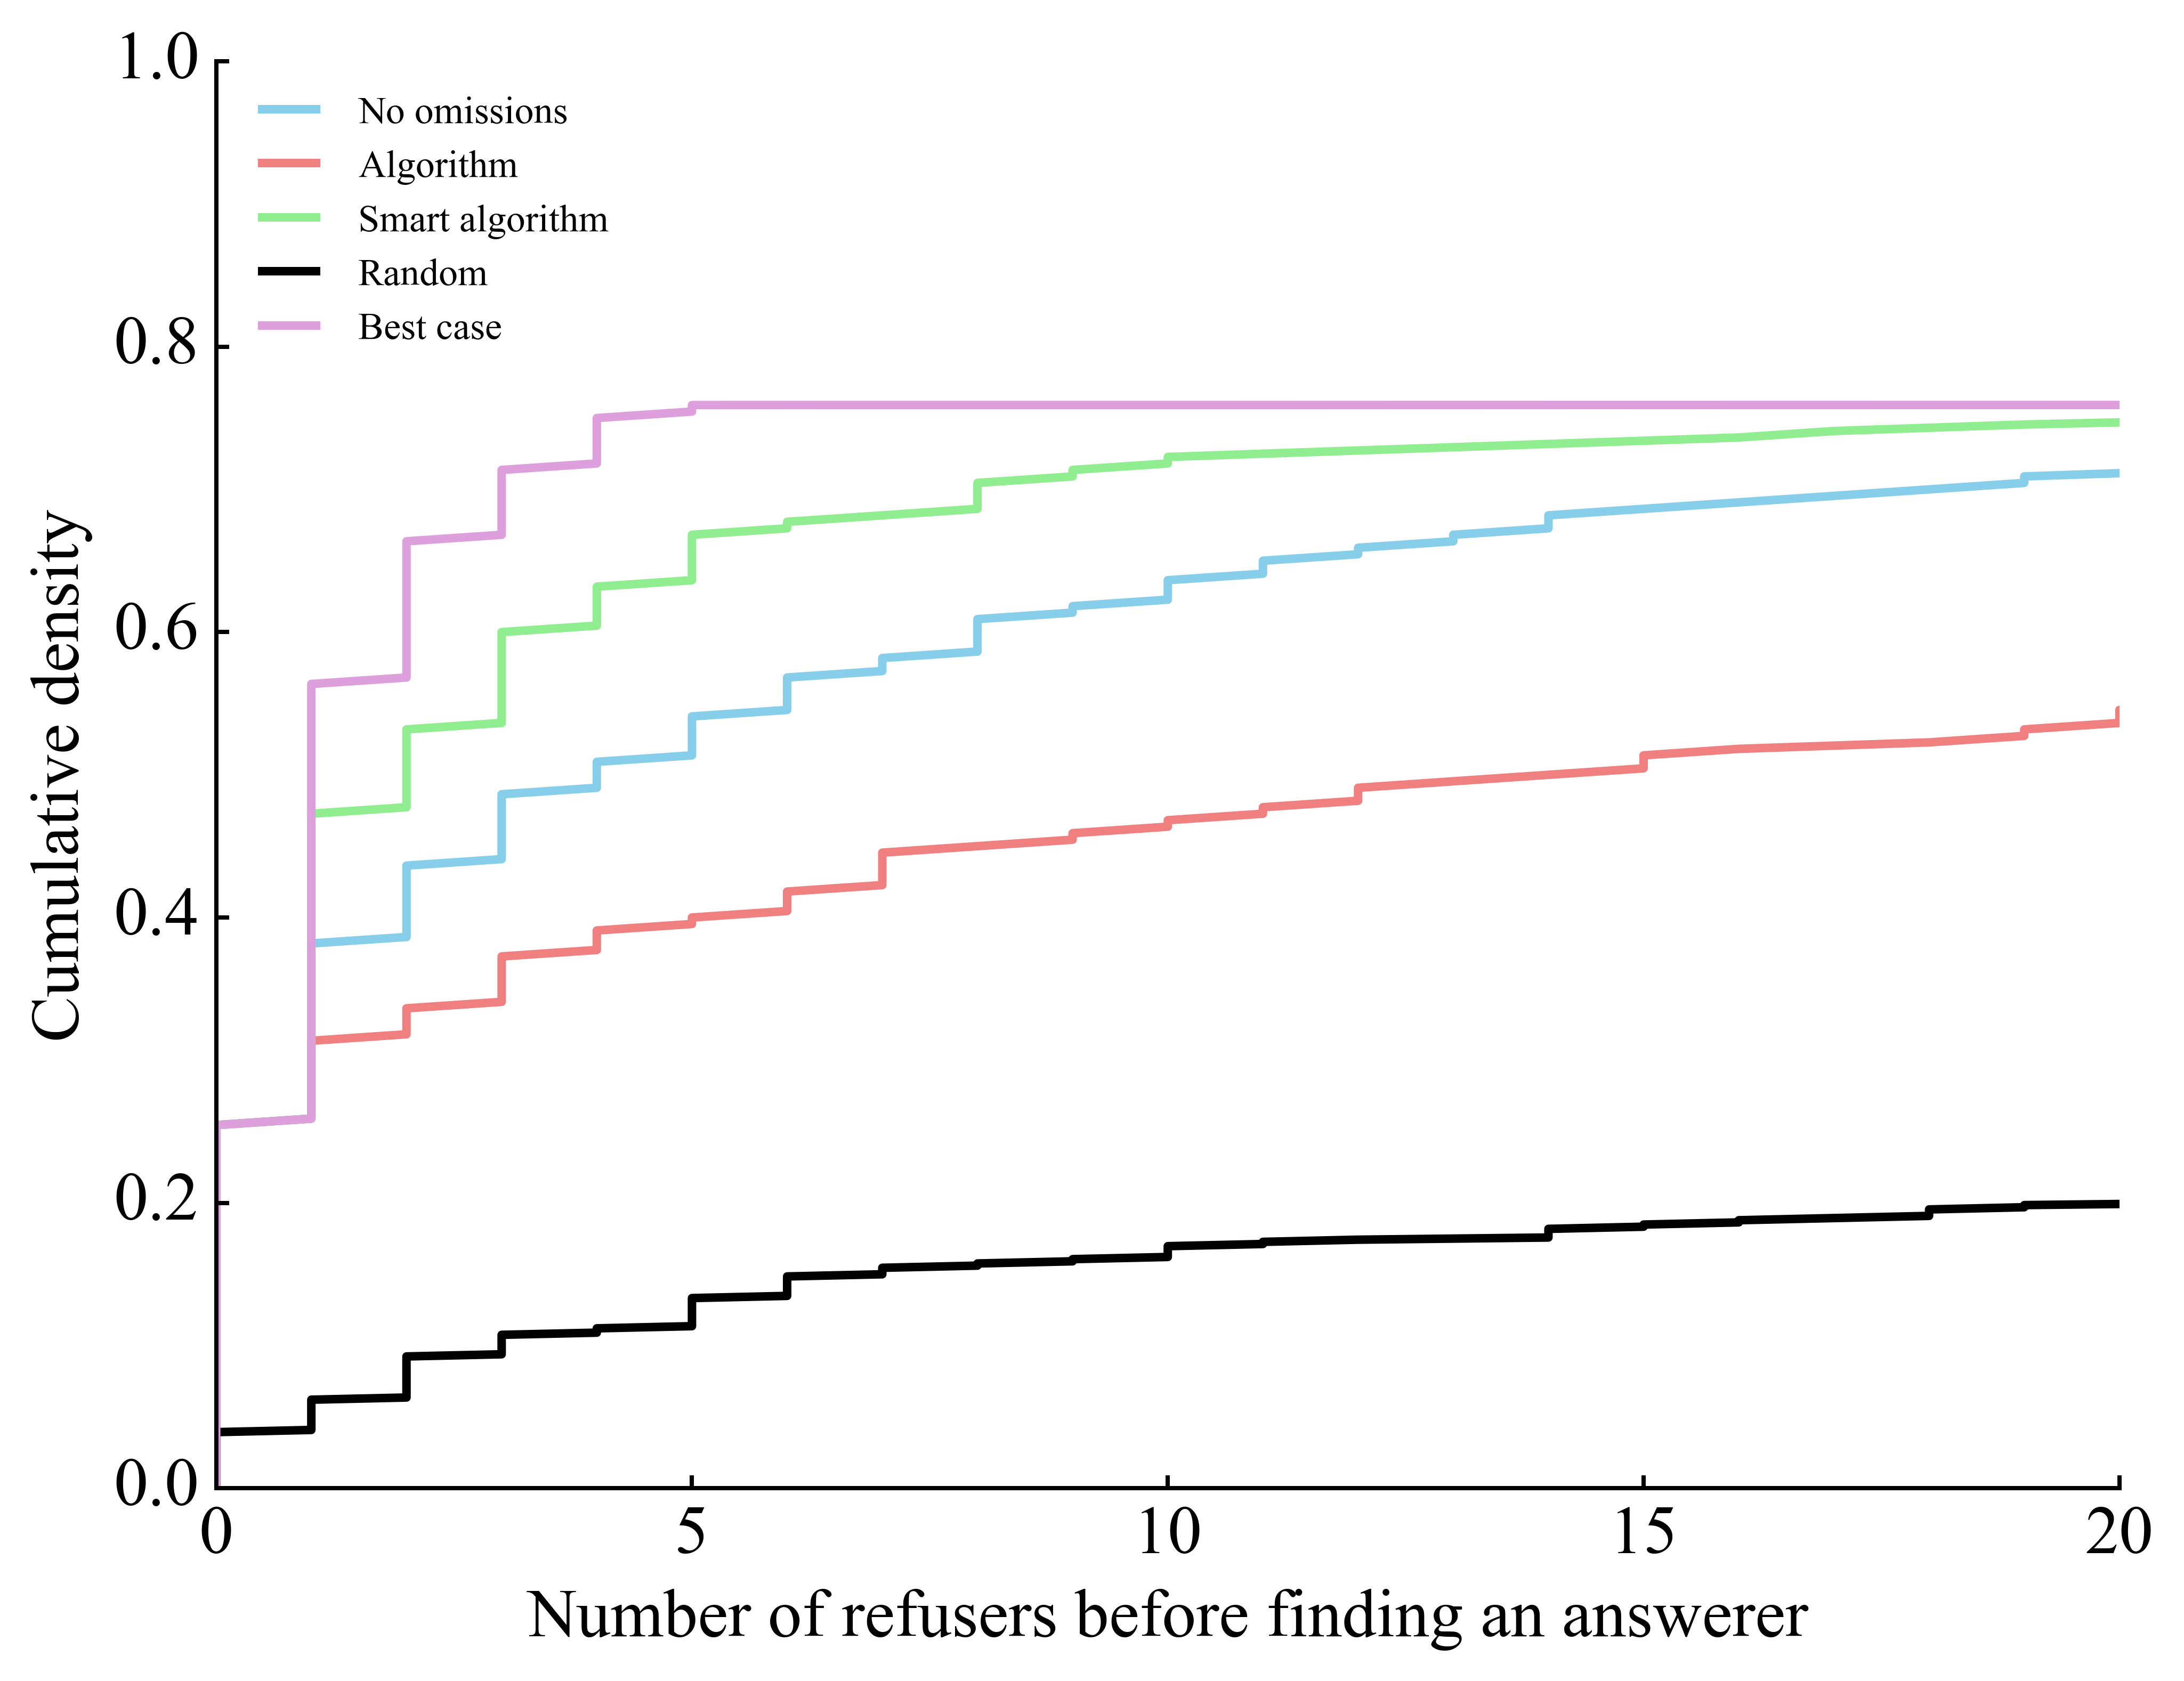

In [40]:

a=list(np.array(numbers_normal,dtype=np.int16))
b=list(np.array(numbers_alg,dtype=np.int16))
d=list(np.array(random,dtype=np.int16))
e=list(np.array(best,dtype=np.int16))
f=list(np.array(commenter,dtype=np.int16))
g=list(np.array(total_random,dtype=np.int16))
h=list(np.array(guess,dtype=np.int16))

a.sort()
b.sort()
#c.sort()
d.sort()
e.sort()
f.sort()
g.sort()
h.sort()
#yvals0=np.arange(len(c))/float(len(c))
yvals=np.arange(len(a))/float(len(a))
yvals2=np.arange(len(b))/float(len(b))
yvals3=np.arange(len(d))/float(len(d))
yvals4=np.arange(len(e))/float(len(e))
yvals5=np.arange(len(f))/float(len(f))
yvals6=np.arange(len(g))/float(len(g))
yvals7=np.arange(len(h))/float(len(h))
init_plotting()
plt.xlim(0,20)
plt.ylim(0,1)
plt.xlabel('Number of refusers before finding an answerer',fontsize=16)
plt.ylabel('Cumulative density',fontsize=16)
#plt.grid(True)
#plt.plot( c, yvals0,label="normal" )
plt.plot( a, yvals,label="No omissions",color='SkyBlue',linewidth=2 )
plt.plot(b,yvals2,label="Algorithm",color='LightCoral',linewidth=2)
plt.plot(h,yvals7,label="Smart algorithm",color='lightgreen',linewidth=2)
#plt.plot(d,yvals3,label="Random",color='lightgray',linewidth=2)
plt.plot(g,yvals6,label="Random",color='black',linewidth=2)
plt.plot(e,yvals4,label="Best case",color='plum',linewidth=2)
#plt.plot(f,yvals5,label="Commenters",color='burlywood',linewidth=2)
plt.legend(loc="upper left",fontsize=9)
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/validation_travel.eps', bbox_inches='tight')

In [ ]:
number_refusers=[len(set(ans)) if len(set(ans))>0 else 500 for ans in total_refusers ]
number_refusers.sort()
yvals=np.arange(len(number_refusers))/float(len(number_refusers))

plt.xlabel('Size of C',fontsize=16)
plt.ylabel('Cumulative density',fontsize=16)

plt.grid(True)
plt.xlim(0,80)

plt.plot( np.array(number_answerers), yvals,label='QR' )#*1./13568., yvals )

#plt.legend(loc="lower right")
plt.savefig('ecdf_answerers_closest.pdf', bbox_inches='tight')

In [ ]:
e=[a for sets in answerers for a in sets]

#print(e)

In [ ]:
f = {x:e.count(x) for x in e}

In [ ]:
b, c = np.array(f.keys()).astype(int), np.array(f.values())
print(len(c))
hist,bin_edges=np.histogram(c,bins=120)
    #print(hist)
init_plotting()
plt.bar(bin_edges[:-1], hist, width=1,color='SkyBlue',edgecolor='SkyBlue')
plt.xlabel('Number of questions per candidate answerer',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xlim(0, 120)
plt.ylim(0,25)
plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/load_alg_travel.eps', bbox_inches='tight')
plt.show()

In [ ]:

question=df.loc[df.TypeId==1].iloc[0]
questions=df[df.TypeId==1]
n=len(questions)

training_questions=questions.sample(frac=0.9)
test_questions = questions.loc[~questions.index.isin(training_questions.index)]
print(len(training_questions))
training_set=df.loc[np.logical_or(df.Id.isin(training_questions.Id), df.ParentId.isin(training_questions.Id))]
#print(training_set)
#test_questions=questions[(int(n*size)):]
test_set=df.loc[np.logical_or(df.Id.isin(test_questions.Id),df.ParentId.isin(test_questions.Id))]
#set_questions=df.loc[np.logical_and(df.TypeId==1,df.AnswerCount>0)].iloc[0:1000]
#print(set_questions.iloc[1])
#print(len(set_questions[set_questions.AnswerCount>0]))
set_questions=ordered_questions(question,training_questions)
#print(set_questions.iloc[1])
#print(len(set_questions[set_questions.AnswerCount>0]))
found=False
index=1
answerers=all_answerers(question.Id,df)
print(list(answerers))
while not found:
        #if index>50 or index>=len(set_questions): 
        #    break
        current=set_questions.iloc[index]
        print(current.AnswerCount)
        current_answerers=all_answerers(current.Id,df)
        print(list(current_answerers))
        if len(set(current_answerers).intersection(set(answerers)))>0:
            found=True
        else:
            index+=1
print(index)   
#print(set(answerers))

In [ ]:
print result

In [ ]:
a=list(np.array(result,dtype=np.int16))
#print(a)
a.sort()
yvals=np.arange(len(a))/float(len(a))
plt.xlim(0,50)
plt.xlabel('Index of the closest question answered by the same user')
plt.ylabel('Cumulative density')
plt.grid(True)
plt.plot( a, yvals )
plt.savefig('ecdf_closest.pdf', bbox_inches='tight')

In [ ]:
#### Joint Complexity###

 
#startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=/Users/cepardot/GoogleDrive/EP/Stage/stackoverflowanalysis-188/db/CoreJointComplexity/bin")
 
testPkg = JPackage('com').alblf.jc
Test = testPkg.SuffixTree
numText=len(df.Text[df.TypeId==2])-2
similarity=np.ones((numText,numText))
for i in range(numText):
    a=Test(df.Text[df.TypeId==2][i])
    for j in range((i+1),numText):
        b=Test(df.Text[df.TypeId==2][j])
        similarity[i,j]=similarity[j,i]=a.normalizedJC(b)





In [ ]:
similarity_norm=similarity
max_sim=np.max(similarity[similarity<0.005])
similarity_norm[similarity<0.005]=similarity[similarity<0.005]/max_sim

In [ ]:
similarity

In [ ]:
import matplotlib.pyplot as plt
hist,bin_edges=np.histogram(similarity_norm,bins=10000)
#print(hist)
plt.bar(bin_edges[:-1], hist, width = 1./10000)
plt.xlim(0, 1)
plt.show()  


In [ ]:
af = AffinityPropagation(affinity='precomputed').fit(similarity_norm)
cluster_centers_indices = af.cluster_centers_indices_
clustersA = af.labels_.tolist()
num_clustersA = len(cluster_centers_indices)
order_centroidsA=tfidf_matrixAComplete[cluster_centers_indices,:].todense().argsort()[:, ::-1]
df['clusters']=np.empty(len(df.Text)).fill(np.nan)
df.loc[df.TypeId==1,'clusters']=-1
df.loc[df.TypeId==2,'clusters']=clustersA
cluster_namesA={}
cluster_colorsA={}
for i in range(num_clustersA):
    print("Cluster %d words:" % i, end='')
    alist=[]
    # for ind in order_centroidsA[i, :5]: #replace 6 with n words per cluster
    for ind in np.squeeze(np.asarray(order_centroidsA[i,:5])): #replace 6 with n words per cluster
        alist.append(vocab_frameA.ix[termsA[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
        print(' %s' % vocab_frameA.ix[termsA[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    cluster_namesA[i]=alist
    cluster_colorsA[i]="#%06x" % random.randint(0, 0xFFFFFF)
    print() #add whitespace
    print() #add whitespace
    grouping=df[np.logical_and(df.clusters==i, df.TypeId==2)][['Id','ParentId','UserId']]
    print("Cluster %d parent's Id:" % i, end='')

    for title in grouping.iterrows():
        #print(title[0] + ', ')
        #if title[1]=='nan':
        #    title=str(title[0])
        #else
        #    title=str(title[1])
        print(' (Parent Id: %s, ' % str(title[1].ParentId) + 'Id: %s, ' % str(title[1].Id) + 'UserId: %s), ' % str(title[1].UserId), end='')
    print() #add whitespace
    print() #add whitespace

print()
print()

# User Analysis

Some basic analysis of how users are behaving with respect to clusters. We observe a seemeingly exponential distribution on the frequency of users per number of answers provided. For the top respondents we observe that they tend to have answers in most clusters, thus implying that an 'expert' tends to be able to deal with any topic. This characteristic might be particular to non-technical areas, since its conceivable that experts will specialize in a small number of hard topics. Moreover, as the dataset increases it is important to look at more average users, since many (probably most) of the question won't be answer by experts, but rather by middle ranked users. When we look at a broader range, we observe that users start appearing in only a couple of clusters, which makes more feasible the idea of selecting potential respondents from the clusters identified via text.

In [ ]:
a=np.asarray(df.UserId[np.logical_and(~np.isnan(df.UserId), df.UserId >= 0)].astype(int))
freqs=np.bincount(a)
b=freqs[freqs!=0]
b.sort()
data=b[::-1]
n, bins, patches=plt.hist(data, bins=np.arange(data.min(), data.max()+1))
# = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Number of Users')
plt.title('Number of Texts')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.axis([0, 200, 0, 250])
plt.grid(True)
plt.show()
#c=np.where(freqs>20)[0]
#df[df.UserId.isin(c.tolist())]
#np.bincount(np.asarray(df.clustersKmeans[np.logical_and(df.UserId==101,df.TypeId==2)].astype(int)))



In [ ]:
numberAnswers=[]
numberClustersKmeans=[]
numberClustersAffinity=[]
users=set(df.UserId)
for user in users:
    numberAnswers.append(df.UserId[df.TypeId==2].tolist().count(user))
    numberClustersKmeans.append(len(set(df.clustersKmeans[np.logical_and(df.UserId==user, df.TypeId==2)])))
#    numberClustersAffinity.append(len(set(df.clustersAffinity[np.logical_and(df.UserId==user, df.TypeId==2)])))
#freqsAnswers=np.bincount(np.asarray(numberAnswers))
freqsClustersKmeans=np.bincount(np.asarray(numberClustersKmeans))
#freqsClustersAffinity=np.bincount(np.asarray(numberClustersAffinity))
#freqsAnswers.sort()
#freqsClustersKmeans.sort()
#freqsClustersAffinity.sort()
#dataA=freqsAnswers[freqsAnswers!=0][::-1]
dataCK=freqsClustersKmeans[freqsClustersKmeans!=0][::-1]
#dataCA=freqsClustersAffinity[freqsClustersAffinity!=0][::-1]
#plt.hist(dataA, bins=np.arange(dataA.min(), dataA.max()+1))
#n, bins, patches=plt.hist(dataCK, bins=np.arange(dataCK.min(), dataCK.max()+1))
plt.xlabel('Smarts')
plt.ylabel('Number of Users')
plt.title('Number of Texts')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([0, 200, 0, 250])
plt.grid(True)
plt.show()
#plt.hist(dataCA, bins=np.arange(dataCA.min(), dataCA.max()+1))
print(dataCK)
print(numberClustersKmeans)

In [ ]:
numberAnswers=np.array(numberAnswers)
c=np.where(numberAnswers>5)[0]

#df[df.UserId.isin(c.tolist())]
#np.bincount(np.asarray(df.clustersKmeans[np.logical_and(df.UserId==101,df.TypeId==2)].astype(int)))

numberClustersKmeans=np.array(numberClustersKmeans)

print(numberAnswers[c])
print(numberClustersKmeans[c])
print(c)

In [ ]:
for user in c:
    alist=[]
    for cluster in set(clustersA):
        number_answers_cluster=len(df[np.logical_and(df.UserId==int(df[user:(user+1)].UserId), df.TypeId==2)][df.clustersKmeans==cluster])
        number_answers=len(df[np.logical_and(df.UserId==int(df[user:(user+1)].UserId), df.TypeId==2)])
        alist.append(float(number_answers_cluster)/number_answers)
        print(number_answers)
    print(alist)
    

In [ ]:
df[np.logical_and(df.UserId==int(df[user:(user+1)].UserId), df.TypeId==2)][df.clustersKmeans==0]

In [ ]:
numberClustersAffinity=np.array(numberClustersAffinity)

print(numberAnswers[c])
print(numberClustersAffinity[c])

## Doubling property

In [ ]:
##Only questions

total_cover=[]
total_count=[]
i=0
for user in set(df.UserId):
    print(i)
    i=i+1
    #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
    answers=df[np.logical_and(df.UserId==user, df.TypeId==2)]
    #answersId=answers.Id
    questions=df[np.logical_and(df.Id.isin(answers.ParentId), df.AnswerCount>1)]
    questions=list(set(questions.Id))
    answerers=df[np.logical_and(df.ParentId.isin(np.array(questions)), df.TypeId==2)].UserId
    answerers=list(set(answerers))
    if(user in answerers):
        answerers.remove(user)
    
    number_cover=[]
    cover=[]
    while(questions):
        #print(i)
        i=i+1
        number_in_common=0
        in_common=[]
        common_questions=[]
        for answerer in answerers:
            
            #print(answerer)
            new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
            #new_answersId=answers.Id
            new_questions=set(new_answers.ParentId)
            in_common=list(new_questions.intersection(set(questions)))
            number=len(in_common)
            if number>number_in_common:
                number_in_common=number
                common_questions=in_common
                user_in_common=answerer
                answerers.remove(answerer)
        #print(np.sort(answerers))
        #print(user_in_common)
        #print(np.sort(common_questions))
        if(number_in_common==0):
            #print(questions)
            questions=[]
        else:
            cover.append(user_in_common)
            number_cover.append(number_in_common)
            for element in common_questions:
                questions.remove(element)
            
    total_cover.append(cover)
    total_count.append(len(cover))
        

In [ ]:
##Comments and votes

total_cover=[]
total_count=[]
i=0
for user in set(df.UserId):
    #print(i)
    i=i+1
    #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
    #Posts where the user has commented
    comments=set(dfC[df.UserId==user].ParentId)
    #Posts where the user has voted
    votes=set(dfC[df.UserId==user].ParentId)
    #Union of the 2 sets
    com_votes=list(comments.union(votes))
    
    #ID of questions where the user has answered
    answers1=set(df[np.logical_and(df.UserId==user, df.TypeId==2)].ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    questions1=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Union of both sets
    questions=list(questions1.union(questions2))
    answerers=df[np.logical_and(df.ParentId.isin(np.array(questions)), df.TypeId==2)].UserId
    answerers=list(set(answerers))
    if(user in answerers):
        answerers.remove(user)
    
    number_cover=[]
    cover=[]
    while(questions):
        #print(i)
        i=i+1
        number_in_common=0
        user_in_common=-1
        in_common=[]
        common_questions=[]
        for answerer in answerers:
            
            #print(answerer)
            new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
            #new_answersId=answers.Id
            new_questions=set(new_answers.ParentId)
            in_common=list(new_questions.intersection(set(questions)))
            number=len(in_common)
            if number>number_in_common:
                number_in_common=number
                common_questions=in_common
                user_in_common=answerer
                answerers.remove(answerer)
        #print(np.sort(answerers))
        #print(user_in_common)
        #print(np.sort(common_questions))
        if(number_in_common==0):
            print(questions)
            questions=[]
        else:
            cover.append(user_in_common)
            number_cover.append(number_in_common)
            for element in common_questions:
                questions.remove(element)
            
    total_cover.append(cover)
    total_count.append(len(cover))

In [19]:
#Given an user it returns the list of questions (not asked by the user) with which she has interacted in any way, as well as the ID of the 
#answers defining that interaction.

def find_questions_all(user,df,dfC,dfV):
    #Posts where the user has commented
    comments=set(dfC[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    com_votes=list(comments.union(votes))
    
    
    answers1=df[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    #Id of posts where the user has voted, commented or which is an answer by the user
    ans_com_votes=answersId.union(com_votes)
    #ID of questions where the user has answered
    answers1=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    questions1=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Union of both sets
    questions=questions1.union(questions2)
    ans_com_votes=ans_com_votes.union(questions)
    return list(ans_com_votes), list(questions)

#Given an user it returns the list of questions with which she has interacted in any way except voting, as well as the ID of the 
#answers defining that interaction.
def find_questions_no_votes(user,df,dfC):
    #Posts where the user has commented
    comments=set(dfC[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    com_votes=list(comments)
    
    #ID of questions where the user has answered
    answers1=df[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    ans_com=answersId.union(com_votes)
    answers1=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    questions1=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Union of both sets
    questions=questions1.union(questions2)
    ans_com=ans_com.union(questions)
    return list(ans_com), list(questions)

#Given an user it returns the list of questions with which she has interacted in any way except voting, as well as the ID of the 
#answers defining that interaction.
def find_questions_asked_all(user,df,dfC):
    #Posts where the user has commented
    comments=set(dfC[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    com_votes=list(comments)
    
    #ID of questions where the user has answered
    answers1=df[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    ans_com=answersId.union(com_votes)
    answers1=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    questions1=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Questions that the user has asked
    questions3=set(df[np.logical_and(df.TypeId==1, df.UserId==user)].Id)
    #Union of both sets
    questions=questions1.union(questions2).union(questions3)
    ans_com=ans_com.union(questions)
    return list(ans_com), list(questions)

#Given an user it returns the list of questions which she has answered, as well as the ID of the respective
#answers.
def find_questions_answers(user,df):
    
    #ID of questions where the user has answered
    answers1=df[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    
    answers1=set(answers1.ParentId)
   
    #Parent ID of questions for which the user has voted or commented answers
    #answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    #answers=answers1.union(answers2)
    
    
   
    #Questions corresponding to all the answers
    questions=set(df[np.logical_and(df.Id.isin(answers1), df.AnswerCount>1)].Id)
    #Union of both sets
    answersId=answersId.union(questions)
    return list(answersId), list(questions)

#Given an user it returns the list of questions for which she has voted it or one of its answers, as well as the ID 
#of the respective answers.
def find_questions_votes(user,df,dfV):
    
    #Posts where the user has voted
    votes=set(dfV[dfV.UserId==user].ParentId)
    
    
    
    #Parent ID of questions for which the user has voted answers
    questions1=set(df[np.logical_and(df.Id.isin(votes),df.TypeId==2)].ParentId)
    #Union of both sets
   
    #Questions that the user has voted or commented in
    questions2=set(df[np.logical_and(df.Id.isin(votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    #questions2=set(df[df.Id.isin(answers)].Id)
    #Union of both sets
    questions=questions1.union(questions2)
    votes=votes.union(questions)
    return list(votes), list(questions)

#Given a sequence it returns a list of the duplicated elements
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    # adds all elements it doesn't know yet to seen and all other to seen_twice
    seen_twice = set( x for x in seq if x in seen or seen_add(x) )
    # turn the set into a list (as requested)
    return list( seen_twice )

#Given an user it returns the list of questions for which she has voted it or one of its answers at least twice, as well 
#as the ID of the respective
#answers.
def find_questions_more_votes(user,df,dfV):
    
    #Posts where the user has voted
    votes=set(dfV[dfV.UserId==user].ParentId)
    
    #Parent ID of questions for which the user has voted answers
    questions1=list(df[np.logical_and(df.Id.isin(votes),df.TypeId==2)].ParentId)
    #Union of both sets
   
    #Questions that the user has voted or commented in
    questions2=list(df[np.logical_and(df.Id.isin(votes),df.TypeId==1)].Id)
    questions =questions1+questions2
    questions=set(list_duplicates(questions))
    votes=votes.union(questions)
    return list(votes), list(questions)

#Given an user it returns the list of questions for which she has commented it or one of its answers, as well 
#as the ID of the respective answers.
def find_questions_comments(user,df,dfC):
    
    #Posts where the user has voted
    comments=set(dfC[dfC.UserId==user].ParentId)
    
    
    
    #Parent ID of questions for which the user has voted answers
    questions1=set(df[np.logical_and(df.Id.isin(comments),df.TypeId==2)].ParentId)
    #Union of both sets
   
    #Questions that the user has voted or commented in
    questions2=set(df[np.logical_and(df.Id.isin(comments),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    #questions2=set(df[df.Id.isin(answers)].Id)
    #Union of both sets
    questions=questions1.union(questions2)
    comments=comments.union(questions)
    return comments, list(questions)


#Given an user it returns the list of questions for which she has commenteded it or one of its answers at least twice, 
#as well as the ID of the respective answers.
def find_questions_more_comments(user,df,dfC,n):
    
    #Posts where the user has voted
    comments=set(dfC[dfC.UserId==user].ParentId)
    
    
    
    #Parent ID of questions for which the user has voted answers
    questions1=list(df[np.logical_and(df.Id.isin(comments),df.TypeId==2)].ParentId)
    #Union of both sets
   
    #Questions that the user has voted or commented in
    questions2=list(df[np.logical_and(df.Id.isin(comments),df.TypeId==1)].Id)
   
    questions =questions1+questions2
    questions=set(list_duplicates(questions))
    #Questions corresponding to all the answers
    #questions2=set(df[df.Id.isin(answers)].Id)
    #Union of both sets
    comments=comments.union(questions)
    
    return comments, set(questions)

#Given a set of questions, it returns the respective answerers.
def find_answerers(questions,df,dfC):
    answerers1=set(dfC[dfC.ParentId.isin(np.array(questions))].UserId)
    answerers2=set(df[df.ParentId.isin(np.array(questions))].UserId)
    answerers=list(answerers1.union(answerers2))
    #if(user in answerers):
        #answerers.remove(user)
    return answerers

def find_answerers_no_comments(questions,df):
    #answerers1=set(dfC[dfC.ParentId.isin(np.array(questions))].UserId)
    answerers=set(df[df.ParentId.isin(np.array(questions))].UserId)
    #answerers=list(answerers1.union(answerers2))
    #if(user in answerers):
        #answerers.remove(user)
    return answerers
def find_accepted_answerers(questions,df):
    #answerers1=set(dfC[dfC.ParentId.isin(np.array(questions))].UserId)
    answerers=set(df[df.Id.isin(df[df.Id.isin(np.array(questions))].AcceptedAnswer)].UserId)
    #answerers=list(answerers1.union(answerers2))
    #if(user in answerers):
        #answerers.remove(user)
    return answerers
#Given a list of questions and answerers it returns for each answerer a list of the users who have interacted in the 
#same questions, a list of this questions and the number of them.
def common_elements(questions, answerers,df,dfC):
    number_in_common=0
    user_in_common=-1
    in_common=[]
    common_questions=[]
    for answerer in answerers:
            
    #print(answerer)
        comments, questions_comments=find_questions_answers(answerer,df)
        new_questions=set(questions_comments)
        in_common=list(new_questions.intersection(set(questions)))
        number=len(in_common)
        if number>number_in_common:
            number_in_common=number
            common_questions=in_common
            user_in_common=answerer
            answerers.remove(answerer)
    return number_in_common, common_questions, user_in_common,answerers

def common_elements_old(questions, answerers,df):
    number_in_common=0
    user_in_common=-1
    in_common=[]
    common_questions=[]
    for answerer in answerers:
            
    #print(answerer)
        new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
            #new_answersId=answers.Id
        new_questions=set(new_answers.ParentId)
        in_common=list(new_questions.intersection(set(questions)))
        number=len(in_common)
        if number>number_in_common:
            number_in_common=number
            common_questions=in_common
            user_in_common=answerer
            answerers.remove(answerer)
    return number_in_common, common_questions, user_in_common,answerers


import heapq
#... etc

# replace greedy_set_cover
#@timer
def greedy_set_cover(subsets, parent_set):
    parent_set = set(parent_set)
    max = len(parent_set)
    # create the initial heap. Note 'subsets' can be unsorted,
    # so this is independent of whether remove_redunant_subsets is used.
    heap = []
    for s in subsets:
        # Python's heapq lets you pop the *smallest* value, so we
        # want to use max-len(s) as a score, not len(s).
        # len(heap) is just proving a unique number to each subset,
        # used to tiebreak equal scores.
        heapq.heappush(heap, [max-len(s), len(heap), s])
    results = []
    result_set = set()
    while result_set < parent_set:
        #logging.debug('len of result_set is {0}'.format(len(result_set)))
        best = []
        unused = []
        while heap:
            score, count, s = heapq.heappop(heap)
            if not best:
                best = [max-len(set(s) - result_set), count, s]
                continue
            if score >= best[0]:
                # because subset scores only get worse as the resultset
                # gets bigger, we know that the rest of the heap cannot beat
                # the best score. So push the subset back on the heap, and
                # stop this iteration.
                heapq.heappush(heap, [score, count, s])
                break
            score = max-len(set(s) - result_set)
            if score >= best[0]:
                unused.append([score, count, s])
            else:
                unused.append(best)
                best = [score, count, s]
            #print(best)
        if best:
            add_set = best[2]
        #logging.debug('len of add_set is {0} score was {1}'.format(len(add_set), best[0]))
            results.append(add_set)
            result_set.update(add_set)
        # subsets that were not the best get put back on the heap for next time.
        while unused:
            heapq.heappush(heap, unused.pop())
    return results
#Given a set of questions and a set of answerers, it returns for each user a list of the users whose interests cover 
# her set of interests, as well as the number of such users. 
def grow_cover_old(questions,answerers,total_cover,total_count,df,dfC):
    number_cover=[]
    cover=[]
    while(questions):
        
        number_in_common, common_questions, user_in_common,answerers=common_elements(questions, answerers,df,dfC)
        if(number_in_common==0):
            #print(questions)
            total_cover.append(cover)
            total_count.append(-1)
            return total_cover, total_count  
            #questions=[]
        else:
            cover.append(user_in_common)
            number_cover.append(number_in_common)
            for element in common_questions:
                questions.remove(element)
            
    total_cover.append(cover)
    total_count.append(len(cover))
    return total_cover, total_count
def grow_cover(questions,answerers,total_cover,total_count,df,dfC):
    in_common=[]
    all_in_common=[]
    len_cover=0
    for answerer in answerers:
            
    #print(answerer)
        new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
            #new_answersId=answers.Id
        new_questions=set(new_answers.ParentId)
        shared_questions=new_questions.intersection(set(questions))
        in_common.append(list(shared_questions))
        all_in_common=all_in_common+list(shared_questions)
    #print(set(all_in_common), questions)
    #number_in_common, common_questions, user_in_common,answerers=common_elements(questions, answerers,df,dfC)
    if len(set(questions))==len(set(all_in_common)):
        cover=greedy_set_cover(in_common, questions)
        len_cover=len(cover)
    else:
        cover=[]
        len_cover=-1
    total_cover.append(cover)
    total_count.append(len_cover)
    return total_cover, total_count
#It finds the cover for all users.
def find_cover(df,dfC,dfV):
    total_cover=[]
    total_count=[]
    i=0
    for user in set(df.UserId):
        if user!=-2:
            #print(i)
            i=i+1
            #questions=df[np.logical_and(df.UserId==user,df.TypeId==1)].Id
            votes, questions=find_questions_asked_all(user,df,dfC)
            if len(questions)>5:
                answerers=find_answerers(votes,df,dfC)
                #print(len(answerers))
                total_cover,total_count=grow_cover(questions,answerers,total_cover,total_count,df,dfC)
        
    return total_cover,total_count




In [20]:
def find_questions_no_votes(user,df,dfC):
    #Posts where the user has commented
    comments=np.array(dfC.loc[dfC.UserId==user].ParentId,dtype=np.int16)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    #com_votes=list(comments)
    #com_votes=np.array(comments, dtype=np.int16)
    
    #ID of questions where the user has answered
    answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=np.array(answers1.Id).astype(int)
    #ans_com=answersId.extend(com_votes)
    ans_com=np.concatenate(answersId,comments)
    #ans_com=set(ans_com)
    answers1=np.array(answers1.ParentId, dtype=np.int16)
    #Parent ID of questions for which the user has voted or commented answers
    N=max(df['Id'].values)+1
    names=set(comments)
    idx = np.zeros(N, dtype='bool'); idx[names] = True;
    answers2=np.array(df.loc[np.logical_and(idx[df['Id'].values],df.TypeId==2)].ParentId,dtype=np.int16)
    #answers2=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=np.concatenate(answers1,answers2)#answers1.extend(answers2)
    #Questions that the user has voted or commented in
    questions1=np.array(df.loc[np.logical_and(idx[df['Id'].values],df.TypeId==1)].Id,dtype=np.int16)
    #questions1=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
   
    names=np.array(set(answers), dtype=np.int16)
    idx = np.zeros(N, dtype='bool'); idx[names] = True;
    questions2=np.array(df.loc[np.logical_and(idx[df['Id'].values], df.AnswerCount>1)].Id,dtype=np.int16)
    #questions2=set(df.loc[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Union of both sets
    #questions=questions1.union(questions2)
    questions=np.concatenate(questions1,questions2)
    ans_com=np.concatenate(ans_com,questions)#ans_com.union(questions)
    return list(set(ans_com)), list(set(questions))
def find_questions_no_comments(user,df):
    #Posts where the user has commented
    #comments=set(dfC.loc[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    #com_votes=list(comments)
    
    #ID of questions where the user has answered
    answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    #ans_com=answersId.union(com_votes)
    answers=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    #answers2=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    #answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    #questions1=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df.loc[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #questions2=[df.loc[np.logical_and(df.Id==answer,df.AnswerCount>1)].Id for answer in answers]
    #questions2=set([item for sublist in questions2 for item in sublist])
    
    #Questions that the user has asked
    questions3=set(df.loc[np.logical_and(df.TypeId==1, df.UserId==user)].Id)
    #Union of both sets
    questions=questions2.union(questions3)#.union(questions3)
    ans_com=answersId.union(questions)
    return list(ans_com), list(questions)
def find_questions_asked_all(user,df,dfC):
    #Posts where the user has commented
    comments=set(dfC.loc[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    com_votes=list(comments)
    
    #ID of questions where the user has answered
    answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    ans_com=answersId.union(com_votes)
    answers1=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    answers2=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    questions1=set(df.loc[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    questions2=set(df.loc[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #questions2=[df.loc[np.logical_and(df.Id==answer,df.AnswerCount>1)].Id for answer in answers]
    #questions2=set([item for sublist in questions2 for item in sublist])
    
    #Questions that the user has asked
    questions3=set(df.loc[np.logical_and(df.TypeId==1, df.UserId==user)].Id)
    #Union of both sets
    questions=questions1.union(questions2).union(questions3)
    ans_com=ans_com.union(questions)
    return list(ans_com), list(questions)

#Given an user it returns the list of questions with which she has interacted in any way except voting, as well as the ID of the 
#answers defining that interaction.
def find_questions_asked_all_(user,df,dfC):
    #Posts where the user has commented
    comments=np.array(dfC.loc[dfC.UserId==user].ParentId).astype(int)
    #print(comments)
    #comments=set(dfC.loc[dfC.UserId==user].ParentId)
    #Posts where the user has voted
    #votes=set(dfV[dfV.UserId==user].ParentId)
    #Union of the 2 sets
    #com_votes=list(comments)
    
    #ID of questions where the user has answered
    answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=np.array(answers1.Id).astype(int)
    #print(answersId)
    #ans_com=answersId.extend(com_votes)
    ans_com=np.concatenate((answersId,comments),axis=0)
    #ans_com=set(ans_com)
    answers1=np.array(answers1.ParentId).astype(int)
    #answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    #answersId=set(answers1.Id)
    #ans_com=answersId.union(com_votes)
    #answers1=set(answers1.ParentId)
    #Parent ID of questions for which the user has voted or commented answers
    
    
    names=comments
    
    num=np.max(names) if names.size!=0 else 0
    N=max(num,max(df.Id.values))+1
    
    idx = np.zeros(N, dtype='bool'); idx[names] = True;
    answers2=np.array(df.loc[np.logical_and(idx[df.Id.values],df.TypeId==2)].ParentId).astype(int)
    answers=np.concatenate((answers1,answers2),axis=0)#answers1.extend(answers2)
    #Questions that the user has voted or commented in
    questions1=np.array(df.loc[np.logical_and(idx[df.Id.values],df.TypeId==1)].Id).astype(int)
    
    #answers2=set(df.loc[np.logical_and(idx[df['Id'].values],df.TypeId==2)].ParentId)
    #answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    #answers=answers1.union(answers2)
    #Questions that the user has voted or commented in
    #questions1=set(df.loc[np.logical_and(idx[df['Id'].values],df.TypeId==1)].Id)
    #questions1=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==1)].Id)
   
    #Questions corresponding to all the answers
    names=np.array(list(set(answers))).astype(int)
    num=np.max(names) if names.size!=0 else 0
    N=max(num,max(df.Id.values))+1
    idx = np.zeros(N, dtype='bool'); idx[names] = True;
    questions2=np.array(df.loc[np.logical_and(idx[df.Id.values], df.AnswerCount>1)].Id).astype(int)
    
    
    
    #names=np.array(list(answers), dtype=np.int16)
    #num=max(names) if len(names)>0 else 0
    #N=max(num,max(df['Id'].values))+1
    #idx = np.zeros(N, dtype='bool'); idx[names] = True;
    #questions2=set(df.loc[np.logical_and(idx[df['Id'].values], df.AnswerCount>1)].Id)
    #questions2=set(df[np.logical_and(df.Id.isin(answers), df.AnswerCount>1)].Id)
    #Questions that the user has asked
    questions3=np.array(df.loc[np.logical_and(df.TypeId==1, df.UserId==user)].Id).astype(int)
    #questions3=set(df.loc[np.logical_and(df.TypeId==1, df.UserId==user)].Id)
    #Union of both sets
    questions=np.concatenate((questions1,questions2,questions3),axis=0)
    #questions=questions1.union(questions2).union(questions3)
    #ans_com=ans_com.union(questions)
    ans_com=np.concatenate((ans_com,questions),axis=0)
    return list(set(ans_com)), list(set(questions))

#Given an user it returns the list of questions which she has answered, as well as the ID of the respective
#answers.
def find_questions_answers(user,df):
    
    #ID of questions where the user has answered
    answers1=df.loc[np.logical_and(df.UserId==user, df.TypeId==2)]
    answersId=set(answers1.Id)
    
    answers1=set(answers1.ParentId)
   
    #Parent ID of questions for which the user has voted or commented answers
    #answers2=set(df[np.logical_and(df.Id.isin(com_votes),df.TypeId==2)].ParentId)
    #Union of both sets
    #answers=answers1.union(answers2)
    
    
    #N=max(df['Id'].values)+1
    #names=answers1
    #idx = np.zeros(N, dtype='bool'); idx[names] = True;
    
    #Questions corresponding to all the answers
    #questions=set(df.loc[np.logical_and(idx[df['Id'].values], df.AnswerCount>1)].Id)
    questions=set(df.loc[np.logical_and(df.Id.isin(answers1), df.AnswerCount>1)].Id)
    #Union of both sets
    answersId=answersId.union(questions)
    return list(answersId), list(questions)

#Given a set of questions, it returns the respective answerers.
def find_answerers(questions,df,dfC):
    answerers1=set(dfC[dfC.ParentId.isin(np.array(questions))].UserId)
    answerers2=set(df[df.ParentId.isin(np.array(questions))].UserId)
    answerers=list(answerers1.union(answerers2))
    #if(user in answerers):
        #answerers.remove(user)
    return answerers


def find_answerers_no_comments(questions,df):
    if questions:
        questions=np.array(questions,dtype=np.int16)
        names=questions
        answerers=set(df.loc[df.ParentId.isin(np.array(questions))].UserId)
    else:
        answerers=[]
    return answerers
def find_accepted_answerers(questions,df):
    questions=np.array(questions,dtype=np.int16)
    answerers1=set(dfC[dfC.ParentId.isin(np.array(questions))].UserId)
    #names=questions
    #N=len(df)
    #idx = np.zeros(N, dtype='bool'); idx[names] = True;
    
    #answerers=set(df[df.Id.isin(df.loc[idx[df.Id.values]].AcceptedAnswer)].UserId)
    answerers=list(answerers1.union(answerers2))
    return answerers




import heapq
#... etc

# replace greedy_set_cover
#@timer
def greedy_set_cover(subsets, parent_set):
    parent_set = set(parent_set)
    max = len(parent_set)
    # create the initial heap. Note 'subsets' can be unsorted,
    # so this is independent of whether remove_redunant_subsets is used.
    heap = []
    for s in subsets:
        # Python's heapq lets you pop the *smallest* value, so we
        # want to use max-len(s) as a score, not len(s).
        # len(heap) is just proving a unique number to each subset,
        # used to tiebreak equal scores.
        heapq.heappush(heap, [max-len(s), len(heap), s])
    results = []
    result_set = set()
    while result_set < parent_set:
        #logging.debug('len of result_set is {0}'.format(len(result_set)))
        best = []
        unused = []
        while heap:
            score, count, s = heapq.heappop(heap)
            if not best:
                best = [max-len(set(s) - result_set), count, s]
                continue
            if score >= best[0]:
                # because subset scores only get worse as the resultset
                # gets bigger, we know that the rest of the heap cannot beat
                # the best score. So push the subset back on the heap, and
                # stop this iteration.
                heapq.heappush(heap, [score, count, s])
                break
            score = max-len(set(s) - result_set)
            if score >= best[0]:
                unused.append([score, count, s])
            else:
                unused.append(best)
                best = [score, count, s]
            #print(best)
        if best:
            add_set = best[2]
        #logging.debug('len of add_set is {0} score was {1}'.format(len(add_set), best[0]))
            results.append(add_set)
            result_set.update(add_set)
        # subsets that were not the best get put back on the heap for next time.
        while unused:
            heapq.heappush(heap, unused.pop())
    return results
#Given a set of questions and a set of answerers, it returns for each user a list of the users whose interests cover 
# her set of interests, as well as the number of such users. 
def aux_grow(answerer,df,questions):
    new_answers=df.loc[np.logical_and(df.UserId==answerer, df.TypeId==2)]
    new_questions=set(new_answers.ParentId)
    shared_questions=list(new_questions.intersection(set(questions)))
    return shared_questions
def grow_cover(questions,answerers,df):#,dfC):
    len_cover=0
    in_common=[aux_grow(answerer,df,questions) for answerer in answerers]
    all_in_common=[item for sublist in in_common for item in sublist]
    if len(set(questions))==len(set(all_in_common)):
        cover=greedy_set_cover(in_common, questions)
        len_cover=len(cover)
    else:
        cover=[]
        len_cover=-1
    return len_cover
    #return cover, len_cover
#It finds the cover for all users.
def aux_function(user,df,dfC,index):#,dfC):
    #f = open('index_distr', 'w')
    #f.write(str(index))
    #print >>index_distr, index
    #sys.stdout.flush()
    len_cover=-1
    if user!=-2:
        answers, questions=find_questions_asked_all(user,df,dfC)#find_questions_asked_all(user,df,dfC)
        # if len(questions)>5:
        answerers=find_answerers_no_comments(answers,df)
        len_cover=grow_cover(questions,answerers,df)#,dfC)
    return len_cover

def find_cover(df,dfC):
    total_count=[aux_function(user,df,dfC,index) for index,user in enumerate(set(df.UserId))]
    return total_count


    


In [ ]:
import profile
import cProfile
import re
cProfile.run('find_cover(df)', 'restats')
import pstats
p = pstats.Stats('restats')
p.strip_dirs().sort_stats('cumulative').print_stats(50)
#%timeit total_cover,total_count=find_cover(df,dfC)

In [ ]:
total_count=find_cover(df,dfC)

In [ ]:
total_count=np.array(total_count)
print(len(total_count[total_count==-1]),len(total_count))


In [ ]:
#It returns the distributions of comments, votes, their difference and their ratio. 
def get_distributions(df):#,dfC,dfV):
    number_answers=[]
    #number_votes=[]
    difference=[]
    division=[]
    for user in set(df.UserId):#set(dfV.UserId).union(set(dfC.UserId)):
        #if user!=-2:
            #comments, questions_comments=find_questions_all(user,df,dfC,dfV)
            #votes, questions_votes=find_questions_no_votes(user,df,dfC)
            #comments, questions_comments=find_questions_asked_all(user,df,dfC)
        answers,question_answers=find_questions_no_comments(user,df)
            #votes, questions_votes=find_questions_answers(user,df)
            #if len(question_answers)>5:
        number_answers.append(len(question_answers))
                #number_votes.append(len(questions_votes))
                #difference.append(len(questions_votes)-len(questions_comments))
                #if len(questions_votes)>0:
                   # division.append(len(questions_comments)*1.0/(1.0*len(questions_votes)))
    return number_answers
number_answers=get_distributions(df)#, number_votes, difference, division = get_distributions(df,dfC,dfV)

In [ ]:
import pickle
with open('distributions_math_partial.p') as f:
     results = pickle.load(f)
[total_count, number_answers]=results

In [ ]:
with open('results_travel.p') as f:
    results = pickle.load(f)

In [ ]:
print(tree)

In [ ]:
#It plots the comment distribution. 
def comments_distribution(number_comments):
    number_comments=np.array(number_comments)
    n, bins, patches=plt.hist(number_comments, bins=np.arange(number_comments.min(),100))#total_count.max()+1))
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('Number of comments')
    plt.ylabel('Number of Users')
    plt.title('Distribution of QL in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    plt.savefig('comments_distribution.pdf', bbox_inches='tight')
    plt.show()
comments_distribution(number_comments)

In [ ]:
#It plots the vote distribution. 
def votes_distribution(number_votes):
    number_votes=np.array(number_votes)
    n, bins, patches=plt.hist(number_votes, bins=np.arange(0, 100))#total_count.max()+1))
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('Number of votes')
    plt.ylabel('Number of Users')
    plt.title('Distribution of QR in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    #plt.savefig('votes_distribution.pdf', bbox_inches='tight')
    plt.show() 
votes_distribution(number_votes)

In [ ]:
def QL_QR(number_votes,number_comments):
    number_votes=np.array(number_votes)
    number_comments=np.array(number_comments)
    plt.scatter(number_votes,number_comments)
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('QL')
    plt.ylabel('QR')
    plt.title('Distribution of QR in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    #plt.savefig('votes_distribution.pdf', bbox_inches='tight')
    plt.show() 
QL_QR(number_votes,number_comments)

In [ ]:
number_votes=np.array(number_votes)
number_comments=np.array(number_comments)
print(len(number_votes[number_votes==0]))
print(len(number_comments[number_comments==0]))
print(len(set(dfC.UserId).union(set(dfV.UserId))))
#print(np.sort(n_votes))
print(sum(n_votes))

In [ ]:
#It plots the difference distribution. 
def difference_distribution(difference):
    difference=np.array(difference)
    n, bins, patches=plt.hist(difference, bins=np.arange(-20, 20))#total_count.max()+1))
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('Difference')
    plt.ylabel('Number of Users')
    plt.title('Distribution of the difference between QL and QR for Travel')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    #plt.savefig('difference_distribution.pdf', bbox_inches='tight')
    plt.show()
difference_distribution(difference)

In [ ]:
#It plots the division distribution. 
def division_distribution(division):
    division=np.array(division)
    n, bins, patches=plt.hist(division, bins=np.arange(-20, 20))#total_count.max()+1))
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('Division')
    plt.ylabel('Number of Users')
    plt.title('Distribution of the ratio between QL and QR for Travel')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    plt.savefig('division_distribution.pdf', bbox_inches='tight')
    plt.show()
division_distribution(division)

In [ ]:
def common_elements(questions,answerers):
    common=[]
    number_common=[]
    for anwserer in answerers:
        new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
        #new_answersId=answers.Id
        new_questions=set(new_answers.ParentId)
        common.append(list(new_questions.intersection(set(questions))))
        number_common.append(len(in_common))   

In [ ]:
answers=df[np.logical_and(df.UserId==101, df.TypeId==2)]
questions=df[np.logical_and(df.Id.isin(answers.ParentId), AnswerCount>1)]
questions=list(set(questions.Id))
answerers=df[np.logical_and(df.ParentId.isin(np.array(questions)), df.TypeId==2)].UserId
answerers=df[np.logical_and(df.ParentId.isin(np.array(questions)), df.TypeId==2)].UserId
answerers=list(set(answerers))
answerers.remove(101)
#answerers.remove(-2)
common_questions=[]
number_cover=[]
cover=[]
i=0

while(questions):
        print(i)
        i=i+1
        number_in_common=0
        in_common=[]
        for answerer in answerers:
            
            #print(answerer)
            new_answers=df[np.logical_and(df.UserId==answerer, df.TypeId==2)]
            #new_answersId=answers.Id
            new_questions=set(new_answers.ParentId)
            in_common=list(new_questions.intersection(set(questions)))
            number=len(in_common)
            if number>number_in_common:
                number_in_common=number
                common_questions=in_common
                user_in_common=answerer
                answerers.remove(answerer)
        #print(np.sort(answerers))
        #print(user_in_common)
        #print(np.sort(common_questions))
        if(number_in_common==0):
            print(questions)
            questions=[]
        else:
            cover.append(user_in_common)
            number_cover.append(number_in_common)
            for element in common_questions:
                questions.remove(element)
        
print(cover)





In [ ]:
#It plots the cover distribution. 
def cover_distribution(total_count):
    #print(total_count)
    total_count=np.array(total_count)
    n, bins, patches=plt.hist(total_count, bins=np.arange(total_count.min(), 100))#total_count.max()+1))
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel('Cover size')
    plt.ylabel('Number of Users')
    plt.title('Distribution of cover size for Travel')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    #plt.axis([0, 200, 0, 250])
    plt.grid(True)
    #plt.savefig('cover_distribution.pdf', bbox_inches='tight')
    plt.show()
cover_distribution(total_count)

In [ ]:
def QL_cover(number_answers,cover):
    number_answers=np.array(number_answers)
    cover=np.array(cover)
    init_plotting()
    plt.scatter(number_answers[cover!=-1],cover[cover!=-1],marker='o',color='SkyBlue')
    # = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


    plt.xlabel(r'Size of $L_u$')
    plt.ylabel('Cover number')
    #plt.title('Distribution of QR in the Travel dataset')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.axis([0, 100, 0, 25])
    #plt.grid(True)
    plt.savefig('/Users/cepardot/GoogleDrive/EP/Stage/Report/doubling.eps', bbox_inches='tight')
    plt.show() 
#print(len(number_answers), len(total_count))
QL_cover(number_answers,total_count)


In [ ]:
total_count=np.array(total_count)
number_comments=np.array(number_comments)
print(len(number_comments[total_count>15])*1./len(number_comments))

In [ ]:
len(set(dfC.Id))

In [ ]:
number_of_covers=[]
for user in df.UserId:
    num=0
    for cover in total_cover:
        if user in cover:
            num+=1
    number_of_covers.append(num)

In [ ]:
total_number=np.array(number_of_covers)
n, bins, patches=plt.hist(number_of_covers, bins=np.arange(total_count.min(), 20))#total_count.max()+1))
# = plt.hist(x, 50, normed=1, facecolor='g', alpha=0.75)


plt.xlabel('Number of covers')
plt.ylabel('Number of Users')
plt.title('Travel')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([0, 200, 0, 250])
plt.grid(True)
plt.show()